In [1]:
import json
import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

from parse_data import *
p_group_dict = make_p_group_dict()

import xlrd
import pickle
%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)

pd.set_option('display.float_format', lambda x: '%.5f' % x)


palette_list = list(sns.color_palette("colorblind"))


# 2 -field pipeline

In [2]:
#Define resolution: DO NOT CHANGE - P group is assumed as the resolution
resolution = '2-field'


# Load data:
with open('result_data/full_typing_results_full_dataset.json', 'r') as infile:
    full_typing_dict = json.load(infile)

#Load gold standard data
gold_standard_df = pd.read_pickle('result_data/gs_two_field_df.pkl')

#Load overview of population ethnicity
pop_df = pd.read_csv('/work/nthu/publications/github_file_structure/reference_data/2018_1129_HLA_types_full_1000_Genomes_Project_panel.txt', sep='\t', comment='#')
pop_conversion_dict = {row['Sample ID'] : row['Population'] for i, row in pop_df.iterrows()} 

#Load overview of how the populations are grouped into supergroups
superpop_df = pd.read_csv('../reference_data/1000G_superpopulations.tsv', sep='\t', comment='#')
superpop_conversion_dict = {row['Population Code'].strip() : row['Super Population Code'].strip() for i, row in superpop_df.iterrows()} 

In [3]:
#Function for validating an allele call at a locus:

def validate_call(correct_alleles, predicted_alleles):

    #Start by converting the alleles to the correct resolution
    correct_call_1 = {convert_to_two_field(allele) for allele in correct_alleles[0]}
    correct_call_2 = {convert_to_two_field(allele) for allele in correct_alleles[1]}

    pred_1 = {convert_to_two_field(predicted_alleles[0][0])}
    pred_2 = {convert_to_two_field(predicted_alleles[1][0])}

    try:
        correct_0_pred_0 = list(correct_call_1.intersection(pred_1))
        correct_1_pred_1  = list(correct_call_2.intersection(pred_2))

        option_1 = [correct_0_pred_0, correct_1_pred_1]

        correct_0_pred_1  = list(correct_call_1.intersection(pred_2))
        correct_1_pred_0  = list(correct_call_2.intersection(pred_1))

        option_2 = [correct_0_pred_1, correct_1_pred_0]

        hits_1 = len([i for i in option_1 if i != []])
        hits_2 = len([i for i in option_2 if i != []])

        num_correct_hits = max(hits_1,hits_2)
        
        
    except KeyError as error:
        num_correct_hits = 0
    
    correct_call = [list(correct_call_1), list(correct_call_2)]
    pred_call = [list(pred_1), list(pred_2)]

    return num_correct_hits, correct_call, pred_call

In [4]:
#Load US donor population freqs
us_donor_freqs = dict()
for locus in ['A', 'B', 'C', 'DRB1', 'DQB1']:
    us_donor_freqs[locus] = pd.read_excel(f'/work/nthu/publications/github_file_structure/reference_data/US_population_freqs/{locus}.xls')
    us_donor_freqs[locus] = us_donor_freqs[locus].rename(columns = {locus : 'allele'})

us_doner_freqs_df = pd.concat(us_donor_freqs.values(), ignore_index=True)
us_doner_freqs_df.head()

,allele,AAFA_freq,AAFA_rank,AFA_freq,AFA_rank,AFB_freq,AFB_rank,AINDI_freq,AINDI_rank,AISC_freq,AISC_rank,ALANAM_freq,ALANAM_rank,AMIND_freq,AMIND_rank,API_freq,API_rank,CARB_freq,CARB_rank,CARHIS_freq,CARHIS_rank,CARIBI_freq,CARIBI_rank,CAU_freq,CAU_rank,EURCAU_freq,EURCAU_rank,FILII_freq,FILII_rank,HAWI_freq,HAWI_rank,HIS_freq,HIS_rank,JAPI_freq,JAPI_rank,KORI_freq,KORI_rank,MENAFC_freq,MENAFC_rank,MSWHIS_freq,MSWHIS_rank,NAM_freq,NAM_rank,NCHI_freq,NCHI_rank,SCAHIS_freq,SCAHIS_rank,SCAMB_freq,SCAMB_rank,SCSEAI_freq,SCSEAI_rank,VIET_freq,VIET_rank
0,A*68:06,0.00000,NaN,0.00000,197.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00001,71.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,194.00000,0.00000,179.00000,0.00000,NaN,0.00000,NaN,0.00009,54.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00017,47.00000,0.00001,83.00000,0.00000,NaN,0.00003,75.00000,0.00010,61.00000,0.00000,NaN,0.00000,NaN
1,A*11:46,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,272.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN
2,A*03:48,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,237.00000,0.00000,231.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN
3,A*02:215,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,241.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,398.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN
4,A*23:05,0.00002,62.00000,0.00003,62.00000,0.00005,62.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00006,62.00000,0.00008,49.00000,0.00014,49.00000,0.00000,204.00000,0.00000,180.00000,0.00000,NaN,0.00000,NaN,0.00005,58.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00003,60.00000,0.00000,NaN,0.00000,NaN,0.00006,62.00000,0.00010,57.00000,0.00000,NaN,0.00000,NaN


In [5]:
#Calculate overall allele frequency across broad race groups (taken from US donor registry)
pop_counts_df = pd.read_csv('../reference_data/US_population_freqs/pupulation_counts.tsv', sep='\t', comment='#')  

broad_race_groups = list()
for race_group in pop_counts_df['Broad race group'].unique():
    race_dict = dict()
    race_dict['Race code'] = race_group
    race_dict['Count'] = sum(pop_counts_df[pop_counts_df['Broad race group'] == race_group]['Count'])
    race_dict['Typed C'] = sum(pop_counts_df[pop_counts_df['Broad race group'] == race_group]['Typed C'])
    race_dict['Typed DQB1'] = sum(pop_counts_df[pop_counts_df['Broad race group'] == race_group]['Typed DQB1'])
    broad_race_groups += [race_dict]

broad_group_counts_df = pd.DataFrame(broad_race_groups)
broad_group_counts_df

,Race code,Count,Typed C,Typed DQB1
0,AFA,483355,117860,19725
1,API,520860,95936,19898
2,NAM,57432,14180,3663
3,HIS,523323,103607,22905
4,CAU,1313780,418013,85521


In [6]:
#Calculate the overall allele (in P group resolution) frequency across all race groups and for the invidicual super population groups

world_count_dict = {pop_group : dict() for pop_group in ['world_freq'] + [f'{group}_freq' for group in broad_group_counts_df['Race code']]}
world_freq_dict = {pop_group : dict() for pop_group in ['world_freq'] + [f'{group}_freq' for group in broad_group_counts_df['Race code']]}


for i, row in us_doner_freqs_df.iterrows():
    allele = row['allele']
    for pop_group in world_freq_dict:

        
        #Find the number of individuals for this locus for each race group 
        if allele.startswith('C'):
            world_counts = dict([row for i, row in broad_group_counts_df[['Race code', 'Typed C']].iterrows()])
        elif allele.startswith('DQB1'):
            world_counts = dict([row for i, row in broad_group_counts_df[['Race code', 'Typed DQB1']].iterrows()])
        else:
            world_counts = dict([row for i, row in broad_group_counts_df[['Race code', 'Count']].iterrows()])

        allele_counts = 0
        #Calculate the total world "allele count" for the allele
        # by multiplying frequency in race groups with the nubmer of individuals in the group
        if pop_group == 'world_freq':
            for pop_group_2 in broad_group_counts_df['Race code']:
                allele_counts += float(us_doner_freqs_df[us_doner_freqs_df['allele'] == allele][f'{pop_group_2}_freq'] * world_counts[pop_group_2])
        else:
            allele_counts += float(us_doner_freqs_df[us_doner_freqs_df['allele'] == allele][f'{pop_group}'] * world_counts[pop_group.replace('_freq', '')])

        #Add counts to dict with counts for all alleles in P group resolution
        allele_p_group = convert_to_two_field(allele.replace('g', ''))

        if allele_p_group in world_count_dict[pop_group]:
            world_count_dict[pop_group][allele_p_group] += allele_counts
        else:
            world_count_dict[pop_group][allele_p_group] = allele_counts

        #print(pop_group)

#Estimate the world frequency by dividing by the total number of individuals tested for this locus in the full dataset
for pop_group, pop_count_dict in world_count_dict.items():
    if pop_group == 'world_freq':
        for allele, count in pop_count_dict.items():
            if allele.startswith('C'):
                total_count = sum(broad_group_counts_df['Typed C'])
            elif allele.startswith('DQB1'):
                total_count = sum(broad_group_counts_df['Typed DQB1'])
            else:
                total_count = sum(broad_group_counts_df['Count'])

            allele_freq = count / total_count

            world_freq_dict[pop_group][allele] = allele_freq
    else:
        for allele, count in pop_count_dict.items():
            pop_count_row = broad_group_counts_df[broad_group_counts_df['Race code'] == pop_group.replace('_freq', '')]

            if allele.startswith('C'):
                total_count = pop_count_row['Typed C'].values[0]
            elif allele.startswith('DQB1'):
                total_count = pop_count_row['Typed DQB1'].values[0]
            else:
                total_count = pop_count_row['Count'].values[0]

            allele_freq = count / total_count

            world_freq_dict[pop_group][allele] = allele_freq

mhc_freq_df = pd.DataFrame(world_freq_dict).reset_index().rename(columns={'index' : 'allele'})
mhc_freq_df.sort_values('world_freq', ascending=False).head()

,allele,world_freq,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq
639,A*02:01,0.20172,0.12223,0.08435,0.26508,0.20955,0.27160
2873,DQB1*03:01,0.19505,0.18509,0.18486,0.23702,0.20147,0.19620
2870,DQB1*02:01,0.19496,0.21446,0.13067,0.16980,0.17499,0.21185
2090,C*04:01,0.13462,0.20596,0.09612,0.13232,0.16803,0.11515
2125,C*07:01,0.12846,0.11682,0.05546,0.11619,0.10370,0.15505


In [7]:
#Split gold standard typing into two and choose the most frequent one
gold_standard_df.index.name = None

gs_split_dict = dict()
for sample, row in gold_standard_df.iterrows():
    gs_split_dict[sample] = dict()
    for locus in gold_standard_df.columns:
        gs_split_dict[sample][f'{locus}.1'] = row[locus][0]
        gs_split_dict[sample][f'{locus}.2'] = row[locus][1]

gs_split_df = pd.DataFrame(gs_split_dict).T
gs_split_df.head()

,A.1,A.2,B.1,B.2,C.1,C.2,DRB1.1,DRB1.2,DQB1.1,DQB1.2
NA06985,[A*03:01],[A*02:01],[B*07:02],[B*57:01],[C*07:02],[C*06:02],[DRB1*15:01],[DRB1*15:01],[DQB1*06:02],[DQB1*06:02]
NA06986,[A*03:01],[A*32:01],[B*44:03],[B*44:03],[C*04:01],[C*16:01],[DRB1*07:01],[DRB1*07:01],[DQB1*02:02],[DQB1*02:02]
NA06994,[A*02:01],[A*32:01],[B*40:02],[B*08:01],[C*02:02],"[C*07:06, C*07:01]",[DRB1*01:01],[DRB1*04:04],[DQB1*05:01],[DQB1*03:02]
NA07000,[A*02:01],[A*68:01],[B*44:02],[B*40:01],"[C*03:04, C*03:03]",[C*07:04],[DRB1*03:01],[DRB1*11:01],[DQB1*02:01],[DQB1*03:01]
NA07037,[A*30:01],[A*31:01],[B*15:10],[B*40:01],[C*03:04],[C*03:04],[DRB1*04:04],[DRB1*13:02],[DQB1*03:02],[DQB1*06:04]


In [8]:
full_typing_dict.keys()

dict_keys(['1-field', 'pseudosequence', 'P group', '2-field'])

In [9]:
pred_dict = dict()

for sample in gold_standard_df.index:
    pred_dict[sample] = dict()
    for locus in gold_standard_df.columns:
        for tool in full_typing_dict[resolution]:
            if 'prediction' in full_typing_dict[resolution][tool][locus][sample]:
                pred_dict[sample][f'{locus}-{tool}'] = full_typing_dict[resolution][tool][locus][sample]['prediction']
                pred_dict[sample][f'{locus}-{tool}_miscalls'] = full_typing_dict[resolution][tool][locus][sample]['miscalls']
            else:
                pred_dict[sample][f'{locus}-{tool}'] = ''
                pred_dict[sample][f'{locus}-{tool}_miscalls'] = 0

miscalls_df = pd.DataFrame(pred_dict).T

miscalls_overview_df = gold_standard_df.join(miscalls_df)

for locus in gold_standard_df.columns:
    miscalls_overview_df[f'{locus}-consensus_miscall'] = miscalls_overview_df[f'{locus}-Kourami_miscalls'] + miscalls_overview_df[f'{locus}-HLA-LA_miscalls'] + miscalls_overview_df[f'{locus}-Hisatgenotype_miscalls'] + miscalls_overview_df[f'{locus}-Optitype_miscalls']
miscalls_overview_df.sort_values('A-consensus_miscall', ascending=False).head(2)



,A,B,C,DRB1,DQB1,A-Kourami,A-Kourami_miscalls,A-HLA-LA,A-HLA-LA_miscalls,A-Optitype,A-Optitype_miscalls,A-Hisatgenotype,A-Hisatgenotype_miscalls,A-STC-seq,A-STC-seq_miscalls,B-Kourami,B-Kourami_miscalls,B-HLA-LA,B-HLA-LA_miscalls,B-Optitype,B-Optitype_miscalls,B-Hisatgenotype,B-Hisatgenotype_miscalls,B-STC-seq,B-STC-seq_miscalls,C-Kourami,C-Kourami_miscalls,C-HLA-LA,C-HLA-LA_miscalls,C-Optitype,C-Optitype_miscalls,C-Hisatgenotype,C-Hisatgenotype_miscalls,C-STC-seq,C-STC-seq_miscalls,DRB1-Kourami,DRB1-Kourami_miscalls,DRB1-HLA-LA,DRB1-HLA-LA_miscalls,DRB1-Optitype,DRB1-Optitype_miscalls,DRB1-Hisatgenotype,DRB1-Hisatgenotype_miscalls,DRB1-STC-seq,DRB1-STC-seq_miscalls,DQB1-Kourami,DQB1-Kourami_miscalls,DQB1-HLA-LA,DQB1-HLA-LA_miscalls,DQB1-Optitype,DQB1-Optitype_miscalls,DQB1-Hisatgenotype,DQB1-Hisatgenotype_miscalls,DQB1-STC-seq,DQB1-STC-seq_miscalls,A-consensus_miscall,B-consensus_miscall,C-consensus_miscall,DRB1-consensus_miscall,DQB1-consensus_miscall
NA12275,"[[A*23:01], [A*03:01]]","[[B*14:01], [B*07:02]]","[[C*08:02], [C*07:02]]","[[DRB1*12:01], [DRB1*15:01]]","[[DQB1*03:01], [DQB1*06:02]]","[[A*02:110], [A*29:18]]",2,"[[A*23:04], [A*03:123]]",2,"[[A*02:01], [A*03:01]]",1,"[[A*02:95], [A*23:01]]",1,"[[A*03:01], [A*29:03]]",1,"[[B*07:202], [B*44:46]]",2,"[[B*44:46], [B*81:01]]",2,"[[B*14:01], [B*40:01]]",1,"[[B*07:02], [B*14:01]]",0,"[[B*07:02], [B*14:01]]",0,"[[C*03:86], [C*07:51]]",2,"[[C*16:07], [C*03:04]]",2,"[[C*03:04], [C*07:02]]",1,"[[C*08:94], [C*16:01]]",2,"[[C*03:04], [C*08:94]]",2,"[[DRB1*13:02], [DRB1*15:01]]",1,"[[DRB1*13:02], [DRB1*15:01]]",1,,2,"[[DRB1*13:02], [DRB1*12:03]]",2,"[[DRB1*07:01], [DRB1*15:01]]",1,"[[DQB1*06:04], [DQB1*06:02]]",1,"[[DQB1*03:01], [DQB1*06:04]]",1,,2,"[[DQB1*06:04], [DQB1*06:02]]",1,"[[DQB1*06:02], [DQB1*06:04]]",1,6,5,7,6,5
NA20534,"[[A*03:01, A*03:21, A*03:20, A*03:37, A*03:45, A*03:26], [A*11:01, A*11:21]]","[[B*15:146, B*15:104, B*15:102, B*15:01, B*15:140], [B*27:13, B*27:05]]","[[C*01:25, C*01:02], [C*03:20, C*03:03]]","[[DRB1*13:01], [DRB1*08:01]]","[[DQB1*04:02], [DQB1*06:03]]","[[A*30:73], [A*03:88]]",2,"[[A*03:01], [A*11:01]]",0,"[[A*11:01], [A*03:12]]",1,"[[A*03:224], [A*03:265]]",2,"[[A*03:12], [A*11:01]]",1,,2,"[[B*15:137], [B*27:05]]",1,"[[B*15:01], [B*27:05]]",0,"[[B*27:05], [B*15:05]]",1,"[[B*15:342], [B*15:342]]",2,,2,"[[C*01:51], [C*03:04]]",2,"[[C*01:02], [C*03:03]]",0,"[[C*03:03], [C*01:02]]",0,"[[C*01:85], [C*03:03]]",1,"[[DRB1*13:01], [DRB1*08:01]]",0,"[[DRB1*08:01], [DRB1*13:01]]",0,,2,"[[DRB1*08:01], [DRB1*13:01]]",0,"[[DRB1*08:01], [DRB1*13:01]]",0,"[[DQB1*06:03], [DQB1*04:02]]",0,"[[DQB1*04:02], [DQB1*06:03]]",0,,2,"[[DQB1*06:03], [DQB1*04:02]]",0,"[[DQB1*04:02], [DQB1*06:03]]",0,5,4,4,2,2


In [10]:
def most_freq_allele(allele_list):
    most_freq_allele = ('None', -1)
    for allele in allele_list:
        if allele in list(mhc_freq_df['allele']):
            allele_freq = mhc_freq_df[mhc_freq_df['allele'] == allele].iloc[0]['world_freq']
        else:
            allele_freq = 0

        if allele_freq >= most_freq_allele[1]:
            most_freq_allele = (allele, allele_freq)
        
    return most_freq_allele

In [11]:
# Analyse unique miscalls for EAS:

#Create overview table of allele frequencies

#Split the typing results into a row per gold standard allele typing. For each allele typing figure out the miscalls
dqb1_by_pop_group_dict = dict()

for ethnic_group in ['AFR', 'EAS', 'EUR', 'AMR']:
    #Initialise new entry for an allele
    tools = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'Optitype']
    allele_entry = {'count' : 0}
    for tool in tools:
        allele_entry[tool] = 0

    non_represented_alleles = list()
    #Register counts and mistypings for all alleles
    allele_miscalls_freq_dict = dict()
    for sample, row in miscalls_overview_df.iterrows():
        if not superpop_conversion_dict[pop_conversion_dict[sample]] == ethnic_group:
            continue
        for locus in gold_standard_df.columns:
            if not locus == 'DQB1':
                continue
            
            #Find the most frequent of the alleles in gold standard typing
            gs_typing = {0 : [], 1 : []}

            for j in range(2):
                typing_list = [convert_to_two_field(i) for i in row[locus][j]]
                gs_typing[j] = most_freq_allele(typing_list)
                
            if not gs_typing[0] == gs_typing[1]:
                for gs_type, allele_freq in gs_typing.values():
                    if not gs_type in allele_miscalls_freq_dict:
                        allele_miscalls_freq_dict[gs_type] = allele_entry.copy()
                        allele_miscalls_freq_dict[gs_type]['world_freq'] = allele_freq 

                    allele_miscalls_freq_dict[gs_type]['count'] += 1
                    
                    #Register, correct calls by tools
                    for tool in tools:
                        if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}']):
                            allele_miscalls_freq_dict[gs_type][tool] += 1
            else:
                gs_type = gs_typing[0][0]
                if not gs_type in allele_miscalls_freq_dict:
                    allele_miscalls_freq_dict[gs_type] = allele_entry.copy()
                    allele_miscalls_freq_dict[gs_type]['world_freq'] = allele_freq 

                allele_miscalls_freq_dict[gs_type]['count'] += 2

                #Register, correct calls by tools
                for tool in tools:
                    if miscalls_overview_df.loc[sample, f'{locus}-{tool}'] == '':
                        continue
                    if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}'][0]):
                        allele_miscalls_freq_dict[gs_type][tool] += 1
                    if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}'][1]):
                        allele_miscalls_freq_dict[gs_type][tool] += 1           

    #Calculate mistyping rate for all tools
    for gs_type in allele_miscalls_freq_dict:
        for tool in tools:
            if (tool == 'Optitype') and (gs_type.startswith('D')):
                continue
            allele_miscalls_freq_dict[gs_type][f'{tool}-accuracy'] = allele_miscalls_freq_dict[gs_type][tool] / allele_miscalls_freq_dict[gs_type]['count']

    miscall_freq_df = pd.DataFrame(allele_miscalls_freq_dict).T.reset_index().rename(columns = {'index' : 'allele'})

    miscall_freq_df['study_freq'] = miscall_freq_df['count'] / (sum(miscall_freq_df['count']) / 5)
    miscall_freq_df['freq_diff'] = abs(miscall_freq_df['study_freq'] - miscall_freq_df['world_freq'])

    miscall_population_freq_df = pd.merge(miscall_freq_df, mhc_freq_df, on=['allele', 'world_freq'])

    dqb1_by_pop_group_dict[ethnic_group] = miscall_population_freq_df.sort_values('world_freq', ascending=False)

In [12]:
#Load coverage overview:

cov_df = pd.read_csv('result_data/sample_depth.csv', index_col=[0])
cov_df['Ethnic Group'] = [superpop_conversion_dict[pop_conversion_dict[sample]] for sample in cov_df.index]

# miscalls_overview_df[[superpop_conversion_dict[pop_conversion_dict[sample]] == 'EAS' for sample in miscalls_overview_df.index]]
#Analyse EAS DQB1 specifically
eas_sampls = [sample for sample in miscalls_overview_df.index if superpop_conversion_dict[pop_conversion_dict[sample]] == 'EAS'] 
dqb1_cols = [col for col in miscalls_overview_df.columns if ((col.startswith('DQB1')) and not ('Optitype' in col))]


eas_miscalls_df = miscalls_overview_df[miscalls_overview_df.index.isin(eas_sampls)]
eas_miscalls_df = eas_miscalls_df[dqb1_cols]
eas_miscalls_df = eas_miscalls_df.join(cov_df)
eas_miscalls_df['DQB1-consensus_miscall'] = eas_miscalls_df['DQB1-consensus_miscall'] - eas_miscalls_df['DQB1-STC-seq_miscalls']
eas_miscalls_df.sort_values('DQB1-consensus_miscall', ascending=False).head()


#Add column with most frequent allele:
most_frequent_dict = dict()
for sample_id, row in eas_miscalls_df.iterrows():
    a1 = most_freq_allele(row['DQB1'][0])[0]
    a2 = most_freq_allele(row['DQB1'][1])[0]

    most_frequent_dict[sample_id] = [a1, a2]

df = pd.DataFrame(most_frequent_dict).T
df['DQB1-most_frequent'] = [[row[0], row[1]] for _, row in df.iterrows()]
df = df.drop(columns=[0,1])

eas_miscalls_df = eas_miscalls_df.join(df)
eas_miscalls_df.to_csv('result_data/EAS_miscalls_overview.tsv', sep='\t')
eas_miscalls_df.head()

,DQB1,DQB1-Kourami,DQB1-Kourami_miscalls,DQB1-HLA-LA,DQB1-HLA-LA_miscalls,DQB1-Hisatgenotype,DQB1-Hisatgenotype_miscalls,DQB1-STC-seq,DQB1-STC-seq_miscalls,DQB1-consensus_miscall,mean_depth,Ethnic Group,DQB1-most_frequent
HG00403,"[[DQB1*03:01, DQB1*03:22, DQB1*03:09, DQB1*03:24, DQB1*03:21, DQB1*03:19], [DQB1*06:02]]","[[DQB1*06:02], [DQB1*06:02]]",1,"[[DQB1*06:02], [DQB1*03:01]]",0,"[[DQB1*06:02], [DQB1*06:02]]",1,"[[DQB1*06:02], [DQB1*06:02]]",1,3,75.21000,EAS,"[DQB1*03:01, DQB1*06:02]"
HG00404,"[[DQB1*03:01, DQB1*03:22, DQB1*03:09, DQB1*03:24, DQB1*03:21, DQB1*03:19], [DQB1*03:01, DQB1*03:22, DQB1*03:09, DQB1*03:24, DQB1*03:21, DQB1*03:19]]","[[DQB1*03:01], [DQB1*03:01]]",0,"[[DQB1*03:01], [DQB1*03:01]]",0,"[[DQB1*03:01], [DQB1*03:01]]",0,"[[DQB1*03:01], [DQB1*03:01]]",0,2,105.61000,EAS,"[DQB1*03:01, DQB1*03:01]"
HG00406,"[[DQB1*05:01], [DQB1*05:02]]","[[DQB1*05:01], [DQB1*05:01]]",1,"[[DQB1*05:01], [DQB1*05:02]]",0,"[[DQB1*05:02], [DQB1*05:01]]",0,,2,1,119.94000,EAS,"[DQB1*05:01, DQB1*05:02]"
HG00407,"[[DQB1*05:02], [DQB1*06:02]]","[[DQB1*05:01], [DQB1*05:01]]",2,"[[DQB1*05:02], [DQB1*06:146]]",1,"[[DQB1*05:02], [DQB1*05:02]]",1,,2,4,74.47000,EAS,"[DQB1*05:02, DQB1*06:02]"
HG00418,"[[DQB1*03:01, DQB1*03:22, DQB1*03:09, DQB1*03:24, DQB1*03:21, DQB1*03:19], [DQB1*03:01, DQB1*03:22, DQB1*03:09, DQB1*03:24, DQB1*03:21, DQB1*03:19]]",,2,"[[DQB1*03:157], [DQB1*03:103]]",2,"[[DQB1*03:01], [DQB1*03:10]]",1,,2,5,100.14000,EAS,"[DQB1*03:01, DQB1*03:01]"


In [13]:
#Analyse DQB1 specifically
dqb1_cols = [col for col in miscalls_overview_df.columns if ((col.startswith('DQB1')) and not ('Optitype' in col))]


miscalls_most_frequent_df = miscalls_overview_df.copy()
miscalls_most_frequent_df = miscalls_most_frequent_df[dqb1_cols]
miscalls_most_frequent_df = miscalls_most_frequent_df.join(cov_df)
miscalls_most_frequent_df['DQB1-consensus_miscall'] = miscalls_most_frequent_df['DQB1-consensus_miscall'] - miscalls_most_frequent_df['DQB1-STC-seq_miscalls']
miscalls_most_frequent_df.sort_values('DQB1-consensus_miscall', ascending=False).head()


#Add column with most frequent allele:
most_frequent_dict = dict()
for sample_id, row in miscalls_most_frequent_df.iterrows():
    a1 = most_freq_allele(row['DQB1'][0])[0]
    a2 = most_freq_allele(row['DQB1'][1])[0]

    most_frequent_dict[sample_id] = [a1, a2]

df = pd.DataFrame(most_frequent_dict).T
df['DQB1-most_frequent'] = [[row[0], row[1]] for _, row in df.iterrows()]
df = df.drop(columns=[0,1])

miscalls_most_frequent_df = miscalls_most_frequent_df.join(df)
miscalls_most_frequent_df.to_csv('result_data/miscalls_most_frequent_overview.tsv', sep='\t')
miscalls_most_frequent_df.head()

,DQB1,DQB1-Kourami,DQB1-Kourami_miscalls,DQB1-HLA-LA,DQB1-HLA-LA_miscalls,DQB1-Hisatgenotype,DQB1-Hisatgenotype_miscalls,DQB1-STC-seq,DQB1-STC-seq_miscalls,DQB1-consensus_miscall,mean_depth,Ethnic Group,DQB1-most_frequent
NA06985,"[[DQB1*06:02], [DQB1*06:02]]","[[DQB1*06:02], [DQB1*06:02]]",0,"[[DQB1*06:02], [DQB1*06:02]]",0,"[[DQB1*06:02], [DQB1*06:02]]",0,"[[DQB1*06:02], [DQB1*06:02]]",0,2,55.63000,EUR,"[DQB1*06:02, DQB1*06:02]"
NA06986,"[[DQB1*02:02], [DQB1*02:02]]","[[DQB1*02:01], [DQB1*02:18]]",2,"[[DQB1*02:01], [DQB1*02:01]]",2,"[[DQB1*02:02], [DQB1*02:02]]",0,"[[DQB1*02:02], [DQB1*02:18]]",1,5,192.65000,EUR,"[DQB1*02:02, DQB1*02:02]"
NA06994,"[[DQB1*05:01], [DQB1*03:02]]","[[DQB1*05:01], [DQB1*03:02]]",0,"[[DQB1*03:02], [DQB1*05:01]]",0,"[[DQB1*03:02], [DQB1*05:01]]",0,"[[DQB1*03:02], [DQB1*05:01]]",0,2,90.51000,EUR,"[DQB1*05:01, DQB1*03:02]"
NA07000,"[[DQB1*02:01], [DQB1*03:01]]","[[DQB1*02:01], [DQB1*03:01]]",0,"[[DQB1*03:01], [DQB1*02:01]]",0,"[[DQB1*02:01], [DQB1*03:01]]",0,"[[DQB1*02:01], [DQB1*03:01]]",0,2,60.73000,EUR,"[DQB1*02:01, DQB1*03:01]"
NA07037,"[[DQB1*03:02], [DQB1*06:04]]","[[DQB1*06:04], [DQB1*06:04]]",1,"[[DQB1*06:04], [DQB1*03:02]]",0,"[[DQB1*06:04], [DQB1*03:02]]",0,"[[DQB1*06:155], [DQB1*06:155]]",2,1,119.94000,EUR,"[DQB1*03:02, DQB1*06:04]"


# Create locus specific miscall analysis IN P GROUP RESOLUTION

In [14]:
import pickle

with open('result_data/miscalls_overview_p_group_df.pkl', 'rb') as infile:
    miscalls_overview_df = pickle.load(infile)
    
#add ethnic group and mean depth
miscalls_overview_df = miscalls_overview_df.join(miscalls_most_frequent_df[['mean_depth', 'Ethnic Group']])

miscalls_overview_df.head()

,A,B,C,DRB1,DQB1,A-Kourami,A-Kourami_miscalls,A-HLA-LA,A-HLA-LA_miscalls,A-Optitype,A-Optitype_miscalls,A-Hisatgenotype,A-Hisatgenotype_miscalls,A-STC-seq,A-STC-seq_miscalls,B-Kourami,B-Kourami_miscalls,B-HLA-LA,B-HLA-LA_miscalls,B-Optitype,B-Optitype_miscalls,B-Hisatgenotype,B-Hisatgenotype_miscalls,B-STC-seq,B-STC-seq_miscalls,C-Kourami,C-Kourami_miscalls,C-HLA-LA,C-HLA-LA_miscalls,C-Optitype,C-Optitype_miscalls,C-Hisatgenotype,C-Hisatgenotype_miscalls,C-STC-seq,C-STC-seq_miscalls,DRB1-Kourami,DRB1-Kourami_miscalls,DRB1-HLA-LA,DRB1-HLA-LA_miscalls,DRB1-Optitype,DRB1-Optitype_miscalls,DRB1-Hisatgenotype,DRB1-Hisatgenotype_miscalls,DRB1-STC-seq,DRB1-STC-seq_miscalls,DQB1-Kourami,DQB1-Kourami_miscalls,DQB1-HLA-LA,DQB1-HLA-LA_miscalls,DQB1-Optitype,DQB1-Optitype_miscalls,DQB1-Hisatgenotype,DQB1-Hisatgenotype_miscalls,DQB1-STC-seq,DQB1-STC-seq_miscalls,A-consensus_miscall,B-consensus_miscall,C-consensus_miscall,DRB1-consensus_miscall,DQB1-consensus_miscall,mean_depth,Ethnic Group
NA06985,"[[A*03:01], [A*02:01]]","[[B*07:02], [B*57:01]]","[[C*07:02], [C*06:02]]","[[DRB1*15:01], [DRB1*15:01]]","[[DQB1*06:02], [DQB1*06:02]]","[[A*03:01], [A*02:01]]",0,"[[A*02:01], [A*03:01]]",0,"[[A*03:01], [A*02:01]]",0,"[[A*02:01], [A*03:01]]",0,"[[A*02:01], [A*03:01]]",0,"[[B*07:02], [B*07:235]]",1,"[[B*07:02], [B*57:01]]",0,"[[B*57:01], [B*07:02]]",0,"[[B*07:02], [B*57:01]]",0,"[[B*07:02], [B*07:02]]",1,"[[C*07:02], [C*06:02]]",0,"[[C*06:02], [C*07:02]]",0,"[[C*06:02], [C*07:02]]",0,"[[C*06:02], [C*07:02]]",0,"[[C*06:116], [C*07:02]]",1,"[[DRB1*15:01], [DRB1*15:01]]",0,"[[DRB1*15:01], [DRB1*15:01]]",0,,2,"[[DRB1*15:01], [DRB1*15:01]]",0,"[[DRB1*15:01], [DRB1*15:01]]",0,"[[DQB1*06:02], [DQB1*06:02]]",0,"[[DQB1*06:02], [DQB1*06:02]]",0,,2,"[[DQB1*06:02], [DQB1*06:02]]",0,"[[DQB1*06:02], [DQB1*06:02]]",0,0,1,0,2,2,55.63000,EUR
NA06986,"[[A*03:01], [A*32:01]]","[[B*44:03], [B*44:03]]","[[C*04:01], [C*16:01]]","[[DRB1*07:01], [DRB1*07:01]]","[[DQB1*02:01], [DQB1*02:01]]","[[A*03:01], [A*32:01]]",0,"[[A*03:01], [A*32:01]]",0,"[[A*03:01], [A*32:01]]",0,"[[A*03:01], [A*32:01]]",0,"[[A*03:01], [A*74:13]]",1,"[[B*44:03], [B*44:03]]",0,"[[B*44:03], [B*44:03]]",0,"[[B*44:03], [B*44:03]]",0,"[[B*44:03], [B*44:03]]",0,"[[B*44:03], [B*44:03]]",0,"[[C*16:01], [C*04:01]]",0,"[[C*04:01], [C*16:01]]",0,"[[C*16:01], [C*04:01]]",0,"[[C*04:01], [C*16:01]]",0,"[[C*16:85], [C*16:85]]",2,"[[DRB1*07:01], [DRB1*07:01]]",0,"[[DRB1*07:01], [DRB1*07:01]]",0,,2,"[[DRB1*07:01], [DRB1*07:01]]",0,,2,"[[DQB1*02:01], [DQB1*02:18]]",1,"[[DQB1*02:01], [DQB1*02:01]]",0,,2,"[[DQB1*02:01], [DQB1*02:01]]",0,"[[DQB1*02:01], [DQB1*02:18]]",1,0,0,0,2,3,192.65000,EUR
NA06994,"[[A*02:01], [A*32:01]]","[[B*40:02], [B*08:01]]","[[C*02:02], [C*07:01]]","[[DRB1*01:01], [DRB1*04:04]]","[[DQB1*05:01], [DQB1*03:02]]","[[A*32:01], [A*02:01]]",0,"[[A*02:01], [A*32:01]]",0,"[[A*32:01], [A*02:01]]",0,"[[A*32:01], [A*02:01]]",0,"[[A*02:01], [A*32:01]]",0,"[[B*08:01], [B*40:02]]",0,"[[B*08:01], [B*40:02]]",0,"[[B*40:02], [B*08:01]]",0,"[[B*08:01], [B*40:02]]",0,"[[B*08:01], [B*40:02]]",0,"[[C*02:02], [C*07:01]]",0,"[[C*07:01], [C*02:02]]",0,"[[C*02:02], [C*07:01]]",0,"[[C*02:02], [C*07:01]]",0,,2,"[[DRB1*01:01], [DRB1*04:04]]",0,"[[DRB1*01:01], [DRB1*04:04]]",0,,2,"[[DRB1*01:01], [DRB1*04:04]]",0,"[[DRB1*01:01], [DRB1*04:08]]",1,"[[DQB1*05:01], [DQB1*03:02]]",0,"[[DQB1*03:02], [DQB1*05:01]]",0,,2,"[[DQB1*03:02], [DQB1*05:01]]",0,"[[DQB1*03:02], [DQB1*05:01]]",0,0,0,0,2,2,90.51000,EUR
NA07000,"[[A*02:01], [A*68:01]]","[[B*44:02], [B*40:01]]","[[C*03:03, C*03:04], [C*07:04]]","[[DRB1*03:01], [DRB1*11:01]]","[[DQB1*02:01], [DQB1*03:01]]","[[A*68:71], [A*02:01]]",1,"[[A*02:01], [A*68:01]]",0,"[[A*68:01], [A*02:01]]",0,"[[A*68:71], [A*02:01]]",1,"[[A*02:22], [A*68:08]]",2,"[[B*44:02], [B*40:01]]",0,"[[B*40:01], [B*44:02]]",0,"[[B*40:01], [B*44:02]]",0,"[[B*40:01], [B*44:02]]",0,"[[B*40:01], [B*44:02]]",0,,2,"[[C*03:04], [C*07:04]]",0,"[[C*07:04], [C*03:04]]",0,"[[C*07:04], [C*03:04]]",0,"[[C*03:04], [C*07:04]

In [15]:
locus_specific_miscalls_dict = dict()


for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']:
    locus_specific_miscalls_dict[tool] = dict()

    for sample_id, row in miscalls_overview_df.iterrows():
        locus_specific_miscalls_dict[tool][sample_id] = dict()

        ref_typing_1 = row['DQB1'][0][0]
        ref_typing_2 = row['DQB1'][1][0]
        ref_typing = [ref_typing_1, ref_typing_2]
        
        homozygous_site = ref_typing[0] == ref_typing[1]
        miscalls = row[f'DQB1-{tool}_miscalls']
        
        pred = row[f'DQB1-{tool}']

        if (pred != ''): #and (str(pred) != 'nan'):

            pred_1 = pred[0][0]
            pred_2 = pred[1][0]

            homozygous_pred = pred_1 == pred_2
            
            if pred_1 in ref_typing:
                locus_specific_miscalls_dict[tool][sample_id]['A1']  = 'Correct typing'
            else:
                locus_specific_miscalls_dict[tool][sample_id]['A1']  = 'Mistyping'
            
            if (not homozygous_site) and homozygous_pred and (pred_1 in ref_typing):
                locus_specific_miscalls_dict[tool][sample_id]['A2'] = 'False homozygous call'
            elif pred_2 in ref_typing:
                locus_specific_miscalls_dict[tool][sample_id]['A2'] = 'Correct typing'
            else:
                locus_specific_miscalls_dict[tool][sample_id]['A2'] = 'Mistyping'

        else:
            locus_specific_miscalls_dict[tool][sample_id]['A1'] = 'Not called'
            locus_specific_miscalls_dict[tool][sample_id]['A2'] = 'Not called'

        #Why is the typing accuracy higher for A1? (probably bc the predictions are sorted)
        # if tool == 'HLA-LA':
        #     if (pred_1 in ref_typing) and (pred_2 not in ref_typing):
        #         print(sample_id)
        #         print(f"pred: {[pred_1, pred_2]}")
        #         print(f"ref: {ref_typing}")
        #         print()

In [16]:
samples_list = list()

for sample_id, d in locus_specific_miscalls_dict['Kourami'].items():
    if d['A2'] == 'False homozygous call':
        samples_list += [sample_id]

len(miscalls_overview_df[miscalls_overview_df.index.isin(samples_list)][['DQB1', 'DQB1-Kourami']])

38

In [17]:
from collections import Counter

for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']: 
    print(tool)
    dqb1_typing_df = pd.DataFrame(locus_specific_miscalls_dict[tool]).T
    print("Full study:")
    print(Counter(dqb1_typing_df['A1']))
    print(Counter(dqb1_typing_df['A2']))
    
    df = dqb1_typing_df
    false_1 = Counter(df['A1'])['Not called'] + Counter(df['A1'])['Mistyping'] + Counter(df['A1'])['False homozygous call']
    true_1 = Counter(df['A1'])['Correct typing']
    false_2 = Counter(df['A2'])['Not called'] + Counter(df['A2'])['Mistyping'] + Counter(df['A2'])['False homozygous call']
    true_2 = Counter(df['A2'])['Correct typing']

    true = true_1 + true_2
    false = false_1 + false_2

    print(f"Typing accuracy: {true / (true + false)}")

    eas_dqb1_typing_df = dqb1_typing_df[dqb1_typing_df.index.isin(eas_sampls)]

    print("EAS samples")
    print(Counter(eas_dqb1_typing_df['A1']))
    print(Counter(eas_dqb1_typing_df['A2']))
    
    df = eas_dqb1_typing_df
    false_1 = Counter(df['A1'])['Not called'] + Counter(df['A1'])['Mistyping'] + Counter(df['A1'])['False homozygous call']
    true_1 = Counter(df['A1'])['Correct typing']
    false_2 = Counter(df['A2'])['Not called'] + Counter(df['A2'])['Mistyping'] + Counter(df['A2'])['False homozygous call']
    true_2 = Counter(df['A2'])['Correct typing']

    true = true_1 + true_2
    false = false_1 + false_2

    print(f"Typing accuracy: {true / (true + false)}")
    print()

Kourami
Full study:
Counter({'Correct typing': 641, 'Not called': 135, 'Mistyping': 53})
Counter({'Correct typing': 612, 'Not called': 135, 'Mistyping': 44, 'False homozygous call': 38})
Typing accuracy: 0.755729794933655
EAS samples
Counter({'Not called': 45, 'Correct typing': 40, 'Mistyping': 16})
Counter({'Not called': 45, 'Correct typing': 40, 'Mistyping': 11, 'False homozygous call': 5})
Typing accuracy: 0.39603960396039606

HLA-LA
Full study:
Counter({'Correct typing': 814, 'Mistyping': 15})
Counter({'Correct typing': 774, 'Mistyping': 53, 'False homozygous call': 2})
Typing accuracy: 0.9577804583835947
EAS samples
Counter({'Correct typing': 93, 'Mistyping': 8})
Counter({'Correct typing': 86, 'Mistyping': 14, 'False homozygous call': 1})
Typing accuracy: 0.8861386138613861

Hisatgenotype
Full study:
Counter({'Correct typing': 800, 'Mistyping': 29})
Counter({'Correct typing': 692, 'Mistyping': 69, 'False homozygous call': 68})
Typing accuracy: 0.8998793727382388
EAS samples
Counte

In [18]:
locus_specific_miscalls_dict = dict()

homo_preds = list()
for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']:
    locus_specific_miscalls_dict[tool] = dict()
    i = 0
    for sample_id, row in miscalls_overview_df.iterrows():
        i +=1

        id_1 = f'{i}_A1'
        id_2 = f'{i}_A2'

        locus_specific_miscalls_dict[tool][id_1] = dict()
        locus_specific_miscalls_dict[tool][id_2] = dict()

        locus_specific_miscalls_dict[tool][id_1]['sample_id'] = sample_id
        locus_specific_miscalls_dict[tool][id_2]['sample_id'] = sample_id       
   

        ref_typing_1 = row['DQB1'][0][0]
        ref_typing_2 = row['DQB1'][1][0]
        ref_typing = [ref_typing_1, ref_typing_2]
        # if sample_id == 'NA06986':
        #     print(row['DQB1'])
        #     sys.exit()

        locus_specific_miscalls_dict[tool][id_1]['allele'] = ref_typing_1
        locus_specific_miscalls_dict[tool][id_2]['allele'] = ref_typing_2
        
        homozygous_site = ref_typing_1 == ref_typing_2
        miscalls = row[f'DQB1-{tool}_miscalls']
        
        pred = row[f'DQB1-{tool}']

        if (pred != ''): #and (str(pred) != 'nan'):
            
            pred_1 = pred[0][0]
            pred_2 = pred[1][0]

            locus_specific_miscalls_dict[tool][id_1]['pred_allele'] = [pred_1, pred_2]
            locus_specific_miscalls_dict[tool][id_2]['pred_allele'] = [pred_1, pred_2]

            homozygous_pred = pred_1 == pred_2
            if (tool == 'HLA-LA') and (homozygous_pred):
                homo_preds += [sample_id]
            
            if ref_typing_1 in str(pred):
                locus_specific_miscalls_dict[tool][id_1]['typing_result']  = 'Correct typing'
            elif (not homozygous_site) and homozygous_pred and (ref_typing_2 in str(pred)):
                locus_specific_miscalls_dict[tool][id_1]['typing_result'] = 'False homozygous call'
            else:
                locus_specific_miscalls_dict[tool][id_1]['typing_result']  = 'Mistyping'
            
            if ref_typing_2 in str(pred):
                if homozygous_site and (not homozygous_pred):
                    locus_specific_miscalls_dict[tool][id_2]['typing_result'] = 'Mistyping'
                else:
                    locus_specific_miscalls_dict[tool][id_2]['typing_result'] = 'Correct typing'
            elif (not homozygous_site) and homozygous_pred and(ref_typing_1 in str(pred)):
                locus_specific_miscalls_dict[tool][id_2]['typing_result'] = 'False homozygous call'
            else:
                locus_specific_miscalls_dict[tool][id_2]['typing_result'] = 'Mistyping'

        else:
            locus_specific_miscalls_dict[tool][id_1]['typing_result'] = 'Not called'
            locus_specific_miscalls_dict[tool][id_2]['typing_result']  = 'Not called'

        # if sample_id == 'NA06986':
        #     print(pred)
        #     print(ref_typing)
        #     print(homozygous_site)
        #     print(homozygous_pred)
        #     print(locus_specific_miscalls_dict[tool][id_2]['typing_result'] )

In [19]:
# Merge columns:
from functools import reduce
df_list = list()

for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']: 
    df = pd.DataFrame(locus_specific_miscalls_dict[tool]).T
    df = df.rename(columns={'pred_allele' : f'{tool}-pred_allele', 'typing_result' : f'{tool}-typing_result'})

    df_list += [df]

allele_specific_typing_df = reduce(lambda  left,right: pd.merge(left,right,on=['sample_id', 'allele'], how='left'), df_list)
allele_specific_typing_df = allele_specific_typing_df.astype('str').drop_duplicates()

# #Add ethnic group, ref typing and depth:
ref_miscalls_df = miscalls_overview_df.rename_axis('sample_id').reset_index()[['sample_id', 'mean_depth', 'Ethnic Group']]

allele_specific_typing_df = pd.merge(allele_specific_typing_df, ref_miscalls_df, on='sample_id', how='left')



df_allele_count = allele_specific_typing_df[['sample_id', 'allele', 'Kourami-typing_result', 'HLA-LA-typing_result', 'Hisatgenotype-typing_result']].drop_duplicates()
homozygous_smaples = [s_id for s_id in df_allele_count['sample_id'] if len(df_allele_count[df_allele_count['sample_id'] == s_id]) == 1]


# #Remove 1000G homozygous samples:
# allele_specific_typing_df = allele_specific_typing_df[allele_specific_typing_df['sample_id'].isin(heterozygous_samples)]

#Add extra row for homozygous samples:
allele_specific_typing_df_homo = allele_specific_typing_df[allele_specific_typing_df['sample_id'].isin(homozygous_smaples)].copy()

allele_specific_typing_df = pd.concat([allele_specific_typing_df, allele_specific_typing_df_homo])

print(len(allele_specific_typing_df))
allele_specific_typing_df.sort_values('HLA-LA-typing_result', ascending=False).head(10)

1658


,sample_id,allele,Kourami-pred_allele,Kourami-typing_result,HLA-LA-pred_allele,HLA-LA-typing_result,Hisatgenotype-pred_allele,Hisatgenotype-typing_result,mean_depth,Ethnic Group
632,NA20760,DQB1*03:03,nan,Not called,"['DQB1*03:34', 'DQB1*03:02']",Mistyping,"['DQB1*03:03', 'DQB1*03:03']",Correct typing,94.47000,EUR
1099,HG00428,DQB1*03:01,"['DQB1*02:39', 'DQB1*02:39']",Mistyping,"['DQB1*02:01', 'DQB1*03:183']",Mistyping,"['DQB1*02:62', 'DQB1*02:01']",Mistyping,87.08000,EAS
91,NA12275,DQB1*06:02,"['DQB1*06:04', 'DQB1*06:02']",Correct typing,"['DQB1*03:01', 'DQB1*06:04']",Mistyping,"['DQB1*06:04', 'DQB1*06:02']",Correct typing,178.81000,EUR
1110,HG00446,DQB1*03:01,nan,Not called,"['DQB1*05:02', 'DQB1*03:157']",Mistyping,"['DQB1*03:04', 'DQB1*05:02']",Mistyping,88.59000,EAS
1104,HG00442,DQB1*03:02,nan,Not called,"['DQB1*05:02', 'DQB1*03:168']",Mistyping,"['DQB1*05:02', 'DQB1*05:97']",Mistyping,95.40000,EAS
1381,HG01170,DQB1*05:03,nan,Not called,"['DQB1*06:92', 'DQB1*04:28']",Mistyping,"['DQB1*06:03', 'DQB1*06:03']",False homozygous call,103.09000,AMR
1004,HG00336,DQB1*05:01,"['DQB1*06:162', 'DQB1*06:162']",Mistyping,"['DQB1*05:62', 'DQB1*06:02']",Mistyping,"['DQB1*05:112', 'DQB1*06:115']",Mistyping,91.43000,EUR
1382,HG01170,DQB1*06:03,nan,Not called,"['DQB1*06:92', 'DQB1*04:28']",Mistyping,"['DQB1*06:03', 'DQB1*06:03']",Correct typing,103.09000,AMR
912,HG00259,DQB1*03:02,nan,Not called,"['DQB1*03:03', 'DQB1*03:01']",Mistyping,"['DQB1*03:03', 'DQB1*03:03']",Mistyping,147.39000,EUR
1179,HG00565,DQB1*05:02,"['DQB1*05:02', 'DQB1*05:02']",Correct typing,"['DQB1*05:02', 'DQB1*03:11']",Mistyping,"['DQB1*05:02', 'DQB1*05:02']",Correct typing,63.93000,EAS


In [20]:
# Read allele specific depth analysis:
#load data
from os import walk
depth_filepath = '/work/msk/one-shot/mhcpub/results/03_mosdepth_cram/'

depth_files = []
for (dirpath, dirnames, filenames) in walk(depth_filepath):
    depth_files.extend(filenames)

depth_results = dict()

for filename in depth_files:
    
    if filename.endswith('.mosdepth.summary.txt'):
        temp_results = pd.read_csv(depth_filepath + filename, sep='\t')
        temp_results.set_index('chrom', inplace=True)
        mean_region_depth = temp_results.loc['total_region', 'mean']
        depth_results[filename[0:7]] = mean_region_depth

depth_df = pd.DataFrame(depth_results, index=['mean_depth']).T
depth_df = depth_df.rename(columns={'mean_depth' : 'mean_depth_reanalysed'})
depth_df = depth_df.rename_axis('sample_id').reset_index()
depth_df.head()

,sample_id,mean_depth_reanalysed
0,HG00345,93.95000
1,HG01168,155.91000
2,HG00235,52.69000
3,HG00126,68.56000
4,NA19035,58.82000


Text(0, 0.5, 'Sample counts')

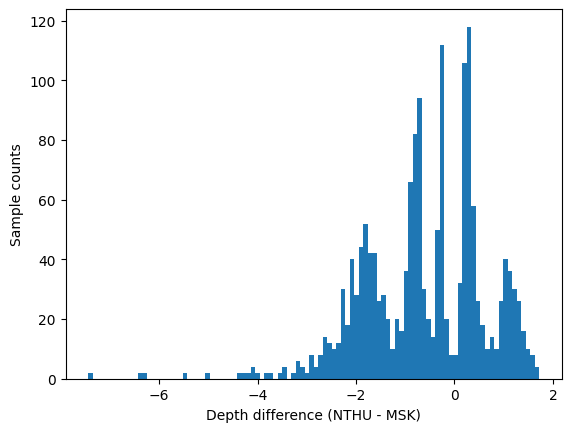

In [21]:
df = pd.merge(allele_specific_typing_df, depth_df, on='sample_id')
df['depth_diff'] = df['mean_depth'] - df['mean_depth_reanalysed']
plt.hist(df['depth_diff'], bins = 100)
plt.xlabel('Depth difference (NTHU - MSK)')
plt.ylabel('Sample counts')

#Conclusion: Depth analysis was fine!

# Allele specific depth analysis

## Load Exon data from IMGT

In [22]:
import subprocess
import requests
import json

imgt_list = list()


for i in range(100):
    if i == 0:
        hla_obj = requests.get('https://www.ebi.ac.uk/cgi-bin/ipd/api/allele?limit=1000&project=HLA')
    else:
        hla_obj = requests.get(f'https://www.ebi.ac.uk/cgi-bin/ipd/api/allele?limit=1000&project=HLA&next={next_cmd}')
    hla_dict = json.loads(hla_obj.text)
    imgt_list += hla_dict['data']

    if hla_dict['meta']['next'] != None:
        next_cmd = hla_dict['meta']['next'].split('next=')[-1]
    else:
        break




In [23]:
HLA_accession_nums = dict()
for entry in imgt_list:
    HLA_accession_nums[entry['name']] = entry['accession']

In [24]:
#Load DQB1 alleles in the 1000G dataset
sample_alleles = miscalls_most_frequent_df.rename_axis('sample_id').reset_index()[['sample_id', 'DQB1-most_frequent']]
sample_alleles

ALLELES = {}
all_alleles = list()
for donor, alleles in sample_alleles[["sample_id", "DQB1-most_frequent"]].values.tolist():
    alleles = sorted(set(json.loads(str(alleles).replace("'", '"'))))
    ALLELES[donor] = alleles
    all_alleles += alleles

unique_alleles = list(set(all_alleles))
print(unique_alleles)

# Match alleles in the 1000G dataset with their accession number (pick the first that matches)
dqb1_alleles_acc_num = dict()

for allele, acc_num in HLA_accession_nums.items():
    two_field_allele = convert_to_two_field(allele)
    if two_field_allele in unique_alleles:
        dqb1_alleles_acc_num[two_field_allele] = acc_num
        
        #Ensure that only the first entry is registered
        unique_alleles.remove(two_field_allele)


['DQB1*06:39', 'DQB1*06:03', 'DQB1*06:04', 'DQB1*02:02', 'DQB1*03:03', 'DQB1*06:02', 'DQB1*04:01', 'DQB1*03:01', 'DQB1*05:02', 'DQB1*06:09', 'DQB1*05:01', 'DQB1*03:04', 'DQB1*02:01', 'DQB1*03:19', 'DQB1*03:02', 'DQB1*05:03', 'DQB1*04:02', 'DQB1*05:04', 'DQB1*06:01', 'DQB1*03:191']


In [25]:
dqb1_exon_pos = dict()

for allele, acc_num in dqb1_alleles_acc_num.items():
    response_obj = requests.get(f'https://www.ebi.ac.uk/cgi-bin/ipd/api/allele/{acc_num}')
    allele_features = json.loads(response_obj.text)
    
    #Find start and end positions of exon 2
    for tron in allele_features['feature']['genomic']:
        if (tron['type'] == 'exon') and (tron['number'] == '2'):
            start = tron['start']
        if (tron['type'] == 'intron') and (tron['number'] == '2'):
            end = tron['start'] - 1
    
    dqb1_exon_pos[allele] = [start, end]

# Calculate allele specific depth for exon 2

In [26]:
#Create allele conversion, as the mapping was done to the most frequent representative of the P group and not necessarily the true 2-field resolution noted

allele_conversion_dict = {
    'DQB1*03:191' : 'DQB1*03:01',
    'DQB1*02:02' : 'DQB1*02:01',
    'DQB1*03:19' : 'DQB1*03:01',
    'DQB1*06:39' : 'DQB1*06:04',
}

# Read allele specific depth analysis:
#load data
from os import walk
import gzip

depth_filepath = '/work/msk/one-shot/mhcpub/results/03_mosdepth_alleles/'

depth_files = []
for (dirpath, dirnames, filenames) in walk(depth_filepath):
    depth_files.extend(filenames)

allele_specific_coverage = dict()

i = 0
for filename in depth_files:

    if filename.endswith('.per-base.bed.gz'):
        sample_id = filename.split('.')[0]

        sample_depth_df = pd.read_csv(depth_filepath + filename, sep='\t', compression='gzip', header=None)
        sample_depth_df.columns = ['allele', 'pos1', 'pos2', 'coverage']
        sample_depth_df['sample_id'] = sample_id

        sample_depth_df['allele'] = [allele_conversion_dict[allele] if allele in allele_conversion_dict else allele for allele in sample_depth_df['allele']]
        
        for allele, df in sample_depth_df.groupby('allele'):
            df_exon2 = df[(df['pos2'] >= int(dqb1_exon_pos[allele][0])) & (df['pos2'] <= int(dqb1_exon_pos[allele][1]))]

            #Convert allele (mapped to which is the most frequent P group) to the 2-field noted in the other data frame
            if allele in allele_conversion_dict:
                allele = allele_conversion_dict[allele]

            i += 1
            allele_specific_coverage[i] = dict()
            allele_specific_coverage[i]['sample_id'] = sample_id
            allele_specific_coverage[i]['allele'] = allele
            allele_specific_coverage[i]['allele_coverage'] = np.mean(df_exon2['coverage'])
        
#         depth_results += [sample_depth_df]


# depth_df = pd.concat(depth_results)
# depth_df = depth_df[depth_df['chrom'] != 'total']
# #depth_df = depth_df.rename_axis('sample_id').reset_index()
# depth_df.head()

In [27]:
allele_specific_coverage_df = pd.DataFrame(allele_specific_coverage).T
allele_specific_df = pd.merge(allele_specific_typing_df, allele_specific_coverage_df, on=['sample_id', 'allele'], how='left').sort_values('sample_id')

print(len(allele_specific_df))
allele_specific_df.head()

1658


,sample_id,allele,Kourami-pred_allele,Kourami-typing_result,HLA-LA-pred_allele,HLA-LA-typing_result,Hisatgenotype-pred_allele,Hisatgenotype-typing_result,mean_depth,Ethnic Group,allele_coverage
1606,HG00096,DQB1*02:01,"['DQB1*02:01', 'DQB1*02:01']",Correct typing,"['DQB1*02:01', 'DQB1*02:01']",Correct typing,"['DQB1*02:01', 'DQB1*02:01']",Correct typing,173.04000,EUR,242.90431
716,HG00096,DQB1*02:01,"['DQB1*02:01', 'DQB1*02:01']",Correct typing,"['DQB1*02:01', 'DQB1*02:01']",Correct typing,"['DQB1*02:01', 'DQB1*02:01']",Correct typing,173.04000,EUR,242.90431
717,HG00097,DQB1*03:01,"['DQB1*03:01', 'DQB1*06:02']",Correct typing,"['DQB1*06:02', 'DQB1*03:01']",Correct typing,"['DQB1*03:01', 'DQB1*06:02']",Correct typing,57.83000,EUR,72.42045
718,HG00097,DQB1*06:02,"['DQB1*03:01', 'DQB1*06:02']",Correct typing,"['DQB1*06:02', 'DQB1*03:01']",Correct typing,"['DQB1*03:01', 'DQB1*06:02']",Correct typing,57.83000,EUR,100.85417
719,HG00099,DQB1*02:01,"['DQB1*02:01', 'DQB1*03:01']",Correct typing,"['DQB1*03:01', 'DQB1*02:01']",Correct typing,"['DQB1*02:01', 'DQB1*03:01']",Correct typing,79.76000,EUR,82.13008


In [28]:
sample_cov_ratio = dict()

for sample_id, df in allele_specific_df.groupby('sample_id'):
    #If homozygous:
    if len(df['allele_coverage'].unique()) == 1:
        sample_cov_ratio[sample_id] = 1
    else:
        c1 = df[df['allele_coverage'] == np.max(df['allele_coverage'])]['allele_coverage'].values[0]
        c2 = df[df['allele_coverage'] != np.max(df['allele_coverage'])]['allele_coverage'].values[0]

        sample_cov_ratio[sample_id] = c1 / c2

cov_ratio_df = pd.DataFrame(sample_cov_ratio, index=[0]).T
cov_ratio_df.columns = ['allele_coverage_ratio']
cov_ratio_df = cov_ratio_df.rename_axis('sample_id').reset_index()

allele_specific_df_2 = pd.merge(allele_specific_df, cov_ratio_df, on='sample_id')

allele_specific_df_2['allele_coverage'] = allele_specific_df_2['allele_coverage'].astype('float')

#Add simple True/False column
for tool in ['Kourami', 'Hisatgenotype', 'HLA-LA']:
    allele_specific_df_2[f'{tool}-typing_result_binary'] = allele_specific_df_2[f'{tool}-typing_result'] == 'Correct typing'


allele_specific_df_eas = allele_specific_df_2[allele_specific_df_2['sample_id'].isin(eas_sampls)]

(array([1226.,  270.,   70.,   28.,   22.,   20.,   10.,    6.,    0.,
           6.]),
 array([ 1.        ,  2.73498305,  4.4699661 ,  6.20494915,  7.9399322 ,
         9.67491525, 11.40989831, 13.14488136, 14.87986441, 16.61484746,
        18.34983051]),
 <BarContainer object of 10 artists>)

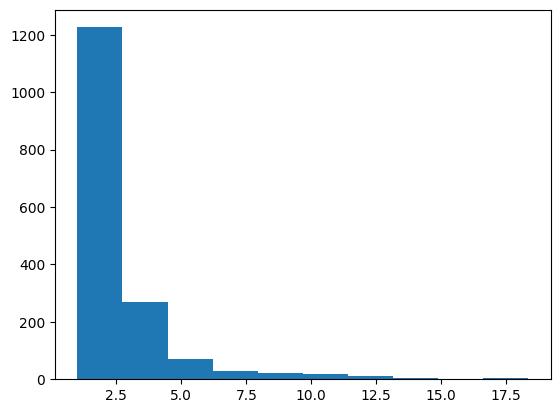

In [29]:
plt.hist(list(allele_specific_df_2['allele_coverage_ratio']))

In [30]:
from collections import Counter

#allele_specific_df_eas.groupby('Kourami-typing_result').apply(lambda x: x.loc['sample_id'].sum()/len(x))

#allele_specific_df_2[allele_specific_df_2['Kourami-typing_result'] == 'False homozygous call']

# from collections import Counter

# for result, df in allele_specific_df_2.groupby('Kourami-typing_result_binary'):
#     print(result)
#     print(Counter(df['allele']))


# for result, df in allele_specific_df_eas.groupby('Kourami-typing_result'):
#     print(result)
#     print(Counter(df['allele']))

# df_all = pd.DataFrame(Counter(allele_specific_df_2['allele']), index=[0])
# df_ratio = pd.DataFrame(Counter(allele_specific_df_2[allele_specific_df_2['allele_coverage_ratio'] > 10]['allele']), index=[1])

# df_both = pd.concat([df_all, df_ratio]).T.fillna(0)
# df_both.columns = ['1000G_count', 'imbalanced_count']
# df_both['1000G_ratio'] = df_both['1000G_count'] / np.sum(df_both['1000G_count'])
# df_both['imbalanced_ratio'] = df_both['imbalanced_count'] / np.sum(df_both['imbalanced_count'])
# df_both.sort_values('imbalanced_ratio')


# samples = allele_specific_df_2[allele_specific_df_2['allele'] == 'DQB1*06:01']['sample_id']
# allele_specific_df_2[(allele_specific_df_2['sample_id'].isin(samples))].sort_values('allele_coverage_ratio').head()# & (allele_specific_df_2['allele'] != 'DQB1*06:01')]



# for allele, df in allele_specific_df_2[allele_specific_df_2['allele'].isin(['DQB1*05:01', 'DQB1*06:01'])].groupby('allele'):
#     print(allele)
#     print(len(df))
#     print(np.mean(df['allele_coverage_ratio']))
#     print(np.mean(df['mean_depth']))
#     print(np.mean(df['allele_coverage']))


# for allele, df in allele_specific_df_eas.groupby('allele'):
#     print(allele)
#     print(len(df))
#     print(np.mean(df['Kourami-typing_result_binary']))
# #    print(np.mean(df['allele_coverage']))


# for allele, df in allele_specific_df_2[allele_specific_df_2['allele'].isin(['DQB1*05:01', 'DQB1*06:02'])].groupby('allele'):
#     print(allele)
#     print(np.mean(df['mean_depth']))
#     print(np.mean(df['allele_coverage']))


# Counter(allele_specific_df_2[allele_specific_df_2['allele_coverage_ratio'] > 10]['allele'])

Text(0.5, 0.98, '')

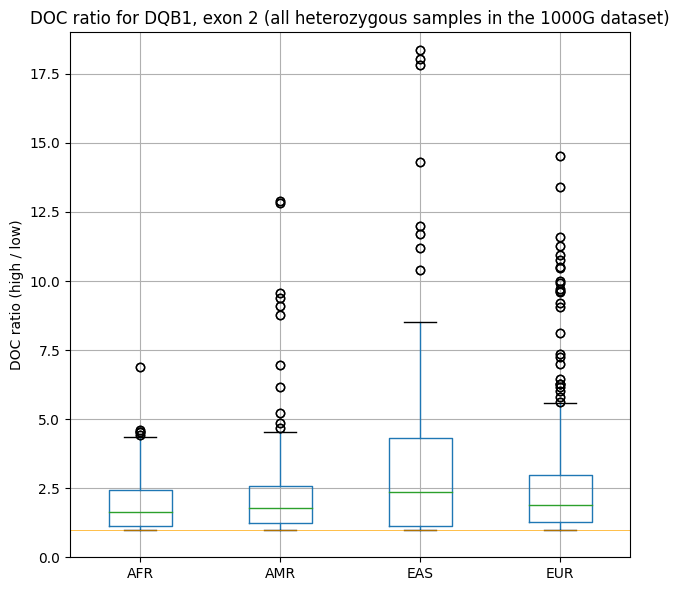

In [31]:
fig, ax = plt.subplots(figsize=(7,7))
allele_specific_df_2[['Ethnic Group', 'allele_coverage_ratio']].boxplot(by='Ethnic Group', ax=ax)
ax.set_title('DOC ratio for DQB1, exon 2 (all heterozygous samples in the 1000G dataset)')
ax.set_xlabel('')
ax.set_ylabel('DOC ratio (high / low)')
ax.set_ylim(0,19)
ax.axhline(1, linewidth=0.5, color='orange')
fig.suptitle('')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


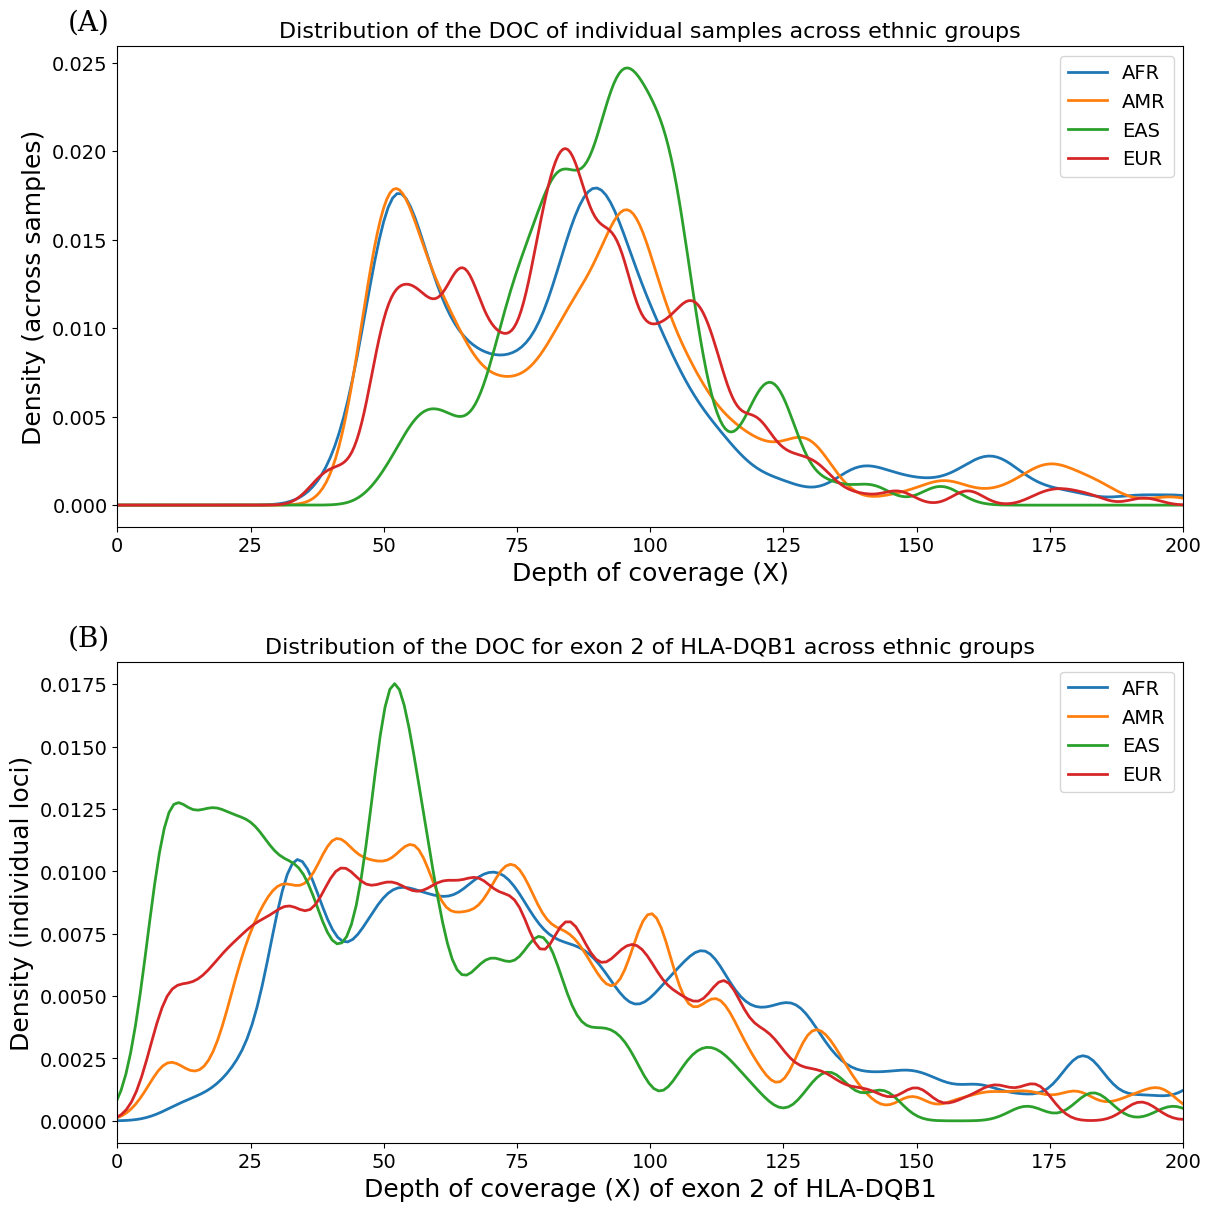

In [32]:
#Plot sequence coverage per population:
import matplotlib.transforms as mtransforms
fig, axs = plt.subplot_mosaic([['(A)'],['(B)']], constrained_layout=True, figsize=(12,12))
figpanels = ['(A)', '(B)']

for label, ax in axs.items():
    if label == '(A)':
        cov_df = pd.read_csv('result_data/sample_depth.csv', index_col=[0])

        cov_df['Ethnic Group'] = [superpop_conversion_dict[pop_conversion_dict[sample]] for sample in cov_df.index]
        cov_wide_df = cov_df.pivot(columns='Ethnic Group', values='mean_depth')

        #fig, ax = plt.subplots(figsize=(15,8))
        cov_wide_df.plot.density(bw_method=0.1,linewidth=2, ax=ax)
        ax.set_xlim(0,200)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel('Depth of coverage (X)\n', size=18)
        ax.set_ylabel('Density (across samples)', size=18)
        ax.set_title('Distribution of the DOC of individual samples across ethnic groups', size=16)
        ax.legend(loc='best', prop={'size': 14})
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')

    if label == '(B)':
        cov_wide_df = allele_specific_df_2.pivot(columns=['Ethnic Group'], values='allele_coverage')

        #fig, ax = plt.subplots(figsize=(15,8))
        cov_wide_df.plot.density(bw_method=0.05,linewidth=2, ax=ax)
        ax.set_xlim(0,200)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel('Depth of coverage (X) of exon 2 of HLA-DQB1', size=18)
        ax.set_ylabel('Density (individual loci)', size=18)
        ax.set_title('Distribution of the DOC for exon 2 of HLA-DQB1 across ethnic groups', size=16)
        ax.legend(loc='best', prop={'size': 14})
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
                fontsize=20, va='bottom', fontfamily='serif')

fig.savefig('paper_plots/FigureS7.jpg', dpi=600)

fig.savefig('paper_plots/FigureS7.eps')

In [33]:
for tool in ['Kourami', 'Hisatgenotype', 'HLA-LA']:
    print(tool)
    high_cov_dqb1 = allele_specific_df_eas[allele_specific_df_eas['allele_coverage'] >= 25][f'{tool}-typing_result_binary']
    low_cov_dqb1 = allele_specific_df_eas[allele_specific_df_eas['allele_coverage'] < 25][f'{tool}-typing_result_binary']

    print(len(high_cov_dqb1))
    print(len(low_cov_dqb1))
    print(sum(high_cov_dqb1) / len(high_cov_dqb1))
    print(sum(low_cov_dqb1) / len(low_cov_dqb1))

Kourami
151
51
0.46357615894039733
0.19607843137254902
Hisatgenotype
151
51
0.8807947019867549
0.45098039215686275
HLA-LA
151
51
0.9139072847682119
0.803921568627451


In [34]:
high_cov_dqb1 = allele_specific_df_eas[allele_specific_df_eas['allele_coverage'] >= 25]['allele']
low_cov_dqb1 = allele_specific_df_eas[allele_specific_df_eas['allele_coverage'] < 25]['allele']

non_asian_dqb1 = allele_specific_df_2[~allele_specific_df_2['sample_id'].isin(eas_sampls)]['allele']

df_high = pd.DataFrame(Counter(list(high_cov_dqb1)), index=[0])
df_low = pd.DataFrame(Counter(list(low_cov_dqb1)), index=[1])

df_other = pd.DataFrame(Counter(list(non_asian_dqb1)), index=[2])

df_both = pd.concat([df_high, df_low, df_other]).T.fillna(0)
df_both.columns = ['high_cov_EAS_alleles', 'low_cov_EAS_alleles', 'non_EAS_alleles']
df_both['high_cov_EAS_alleles_ratio'] = df_both['high_cov_EAS_alleles'] / np.sum(df_both['high_cov_EAS_alleles'])
df_both['low_cov_EAS_alleles_ratio'] = df_both['low_cov_EAS_alleles'] / np.sum(df_both['low_cov_EAS_alleles'])
df_both['non_EAS_alleles_ratio'] = df_both['non_EAS_alleles'] / np.sum(df_both['non_EAS_alleles'])
df_dqb1_allele_distribution_df = df_both.rename_axis('sample_id').reset_index()
df_dqb1_allele_distribution_df = df_dqb1_allele_distribution_df.sort_values('low_cov_EAS_alleles_ratio', ascending=False)

df_dqb1_allele_distribution_df

,sample_id,high_cov_EAS_alleles,low_cov_EAS_alleles,non_EAS_alleles,high_cov_EAS_alleles_ratio,low_cov_EAS_alleles_ratio,non_EAS_alleles_ratio
0,DQB1*03:01,28.00000,18.00000,263.00000,0.18543,0.35294,0.18063
5,DQB1*03:03,22.00000,15.00000,52.00000,0.14570,0.29412,0.03571
10,DQB1*03:02,3.00000,10.00000,154.00000,0.01987,0.19608,0.10577
1,DQB1*06:02,13.00000,4.00000,179.00000,0.08609,0.07843,0.12294
2,DQB1*05:01,3.00000,1.00000,219.00000,0.01987,0.01961,0.15041
3,DQB1*05:02,18.00000,1.00000,31.00000,0.11921,0.01961,0.02129
4,DQB1*06:01,35.00000,1.00000,7.00000,0.23179,0.01961,0.00481
8,DQB1*04:01,4.00000,1.00000,0.00000,0.02649,0.01961,0.00000
6,DQB1*02:01,11.00000,0.00000,253.00000,0.07285,0.00000,0.17376
7,DQB1*05:03,10.00000,0.00000,31.00000,0.06623,0.00000,0.02129


In [35]:
#DQB1*03 analysis for EAS samples by Kourami
tool_dqb1_df_list = list()

for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']:
    kourami_dqb1_03_df_eas = pd.DataFrame(Counter(allele_specific_df_eas[allele_specific_df_eas['allele'].str.startswith('DQB1*03')][f'{tool}-typing_result_binary']), index=[0])
    kourami_dqb1_non_03_df_eas = pd.DataFrame(Counter(allele_specific_df_eas[~allele_specific_df_eas['allele'].str.startswith('DQB1*03')][f'{tool}-typing_result_binary']), index=[1])

    non_eas_df = allele_specific_df_2[~allele_specific_df_2['sample_id'].isin(eas_sampls)]
    kourami_dqb1_03_df = pd.DataFrame(Counter(non_eas_df[non_eas_df['allele'].str.startswith('DQB1*03')][f'{tool}-typing_result_binary']), index=[0])
    kourami_dqb1_non_03_df = pd.DataFrame(Counter(non_eas_df[~non_eas_df['allele'].str.startswith('DQB1*03')][f'{tool}-typing_result_binary']), index=[1])

    kourami_dqb1_df = pd.concat([kourami_dqb1_03_df_eas, kourami_dqb1_non_03_df_eas, kourami_dqb1_03_df, kourami_dqb1_non_03_df]).T.fillna(0)
    kourami_dqb1_df.columns = ['EAS-DQB1*03', 'EAS-Not-DQB1*03', 'Not-EAS-DQB1*03', 'Not-EAS-Not-DQB1*03']
    kourami_dqb1_df['EAS-DQB1*03_ratio'] = kourami_dqb1_df['EAS-DQB1*03'] / np.sum(kourami_dqb1_df['EAS-DQB1*03'])
    kourami_dqb1_df['EAS-Non-DQB1*03_ratio'] = kourami_dqb1_df['EAS-Not-DQB1*03'] / np.sum(kourami_dqb1_df['EAS-Not-DQB1*03'])
    kourami_dqb1_df['Not-EAS-DQB1*03_ratio'] = kourami_dqb1_df['Not-EAS-DQB1*03'] / np.sum(kourami_dqb1_df['Not-EAS-DQB1*03'])
    kourami_dqb1_df['Not-EAS-Non-DQB1*03_ratio'] = kourami_dqb1_df['Not-EAS-Not-DQB1*03'] / np.sum(kourami_dqb1_df['Not-EAS-Not-DQB1*03'])
    kourami_dqb1_df = kourami_dqb1_df.rename_axis('Sample Group').reset_index().T.reset_index()
    kourami_dqb1_df.columns = kourami_dqb1_df.iloc[0]
    kourami_dqb1_df = kourami_dqb1_df[1:]
    kourami_dqb1_df['Tool'] = tool
    tool_dqb1_df_list += [kourami_dqb1_df]

pd.concat(tool_dqb1_df_list)

,Sample Group,False,True,Tool
1,EAS-DQB1*03,70,26,Kourami
2,EAS-Not-DQB1*03,52,54,Kourami
3,Not-EAS-DQB1*03,117,355,Kourami
4,Not-EAS-Not-DQB1*03,166,818,Kourami
5,EAS-DQB1*03_ratio,0.72917,0.27083,Kourami
6,EAS-Non-DQB1*03_ratio,0.49057,0.50943,Kourami
7,Not-EAS-DQB1*03_ratio,0.24788,0.75212,Kourami
8,Not-EAS-Non-DQB1*03_ratio,0.16870,0.83130,Kourami
1,EAS-DQB1*03,16,80,HLA-LA
2,EAS-Not-DQB1*03,7,99,HLA-LA


In [36]:
#Group samples into four categories:
# 1) 2/2
# 2) Correct + False homozygous
# 3) Correct + Mistyping
# 4) 2xmistyping / not called
sample_category = dict()
dfs_list = list()

for tool in ['Kourami', 'Hisatgenotype', 'HLA-LA']:
    for sample_id, df in allele_specific_df_2.groupby('sample_id'):
        if list(df[f'{tool}-typing_result']) == ['Correct typing', 'Correct typing']:
            sample_category[sample_id] = 'Correct'
        elif sorted(list(df[f'{tool}-typing_result'])) == ['Correct typing', 'False homozygous call']:
            sample_category[sample_id] = 'False Homozygous'
        elif sorted(list(df[f'{tool}-typing_result'])) == ['Correct typing', 'Mistyping']:
            sample_category[sample_id] = 'One Mistyping'
        elif sorted(list(df[f'{tool}-typing_result'])) == ['Mistyping', 'Mistyping']:
            sample_category[sample_id] = 'Two mistypings / no prediction'
        elif sorted(list(df[f'{tool}-typing_result'])) == ['Not called', 'Not called']:
            sample_category[sample_id] = 'Two mistypings / no prediction'

    df = pd.DataFrame(sample_category, index=[0]).T.rename_axis('sample_id').reset_index().rename(columns={0 : f'{tool}'})
    dfs_list += [df]

sample_specific_mistypings_df = reduce(lambda  left,right: pd.merge(left,right,on=['sample_id'],how='outer'), dfs_list)

sample_specific_mistypings_df = pd.merge(sample_specific_mistypings_df, allele_specific_df_2[['sample_id', 'Kourami-pred_allele', 'HLA-LA-pred_allele', 'Hisatgenotype-pred_allele', 'Ethnic Group', 'mean_depth', 'allele_coverage_ratio']], on='sample_id').drop_duplicates()

sample_specific_mistypings_df_eas = sample_specific_mistypings_df[sample_specific_mistypings_df['sample_id'].isin(eas_sampls)]

In [37]:
# Counter(list(sample_specific_mistypings_df['Kourami']))
# Counter(list(sample_specific_mistypings_df['Hisatgenotype']))
# Counter(list(sample_specific_mistypings_df['HLA-LA']))

In [38]:
# df_test = sample_specific_mistypings_df_eas[['Kourami', 'Hisatgenotype', 'HLA-LA', 'allele_coverage_ratio']].melt(id_vars = ['allele_coverage_ratio'])
# df_test['Group'] = df_test['variable'].astype('str') + '-' + df_test['value'].astype('str')

# fig, ax = plt.subplots(figsize=(30,12))
# df_test.boxplot(column = 'allele_coverage_ratio', by='Group', ax=ax)
# plt.xticks(rotation=20)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(1, 0, 'HLA-LA-Correct'),
  Text(2, 0, 'HLA-LA-False Homozygous'),
  Text(3, 0, 'HLA-LA-One Mistyping'),
  Text(4, 0, 'HLA-LA-Two mistypings / no prediction'),
  Text(5, 0, 'Hisatgenotype-Correct'),
  Text(6, 0, 'Hisatgenotype-False Homozygous'),
  Text(7, 0, 'Hisatgenotype-One Mistyping'),
  Text(8, 0, 'Hisatgenotype-Two mistypings / no prediction'),
  Text(9, 0, 'Kourami-Correct'),
  Text(10, 0, 'Kourami-False Homozygous'),
  Text(11, 0, 'Kourami-One Mistyping'),
  Text(12, 0, 'Kourami-Two mistypings / no prediction')])

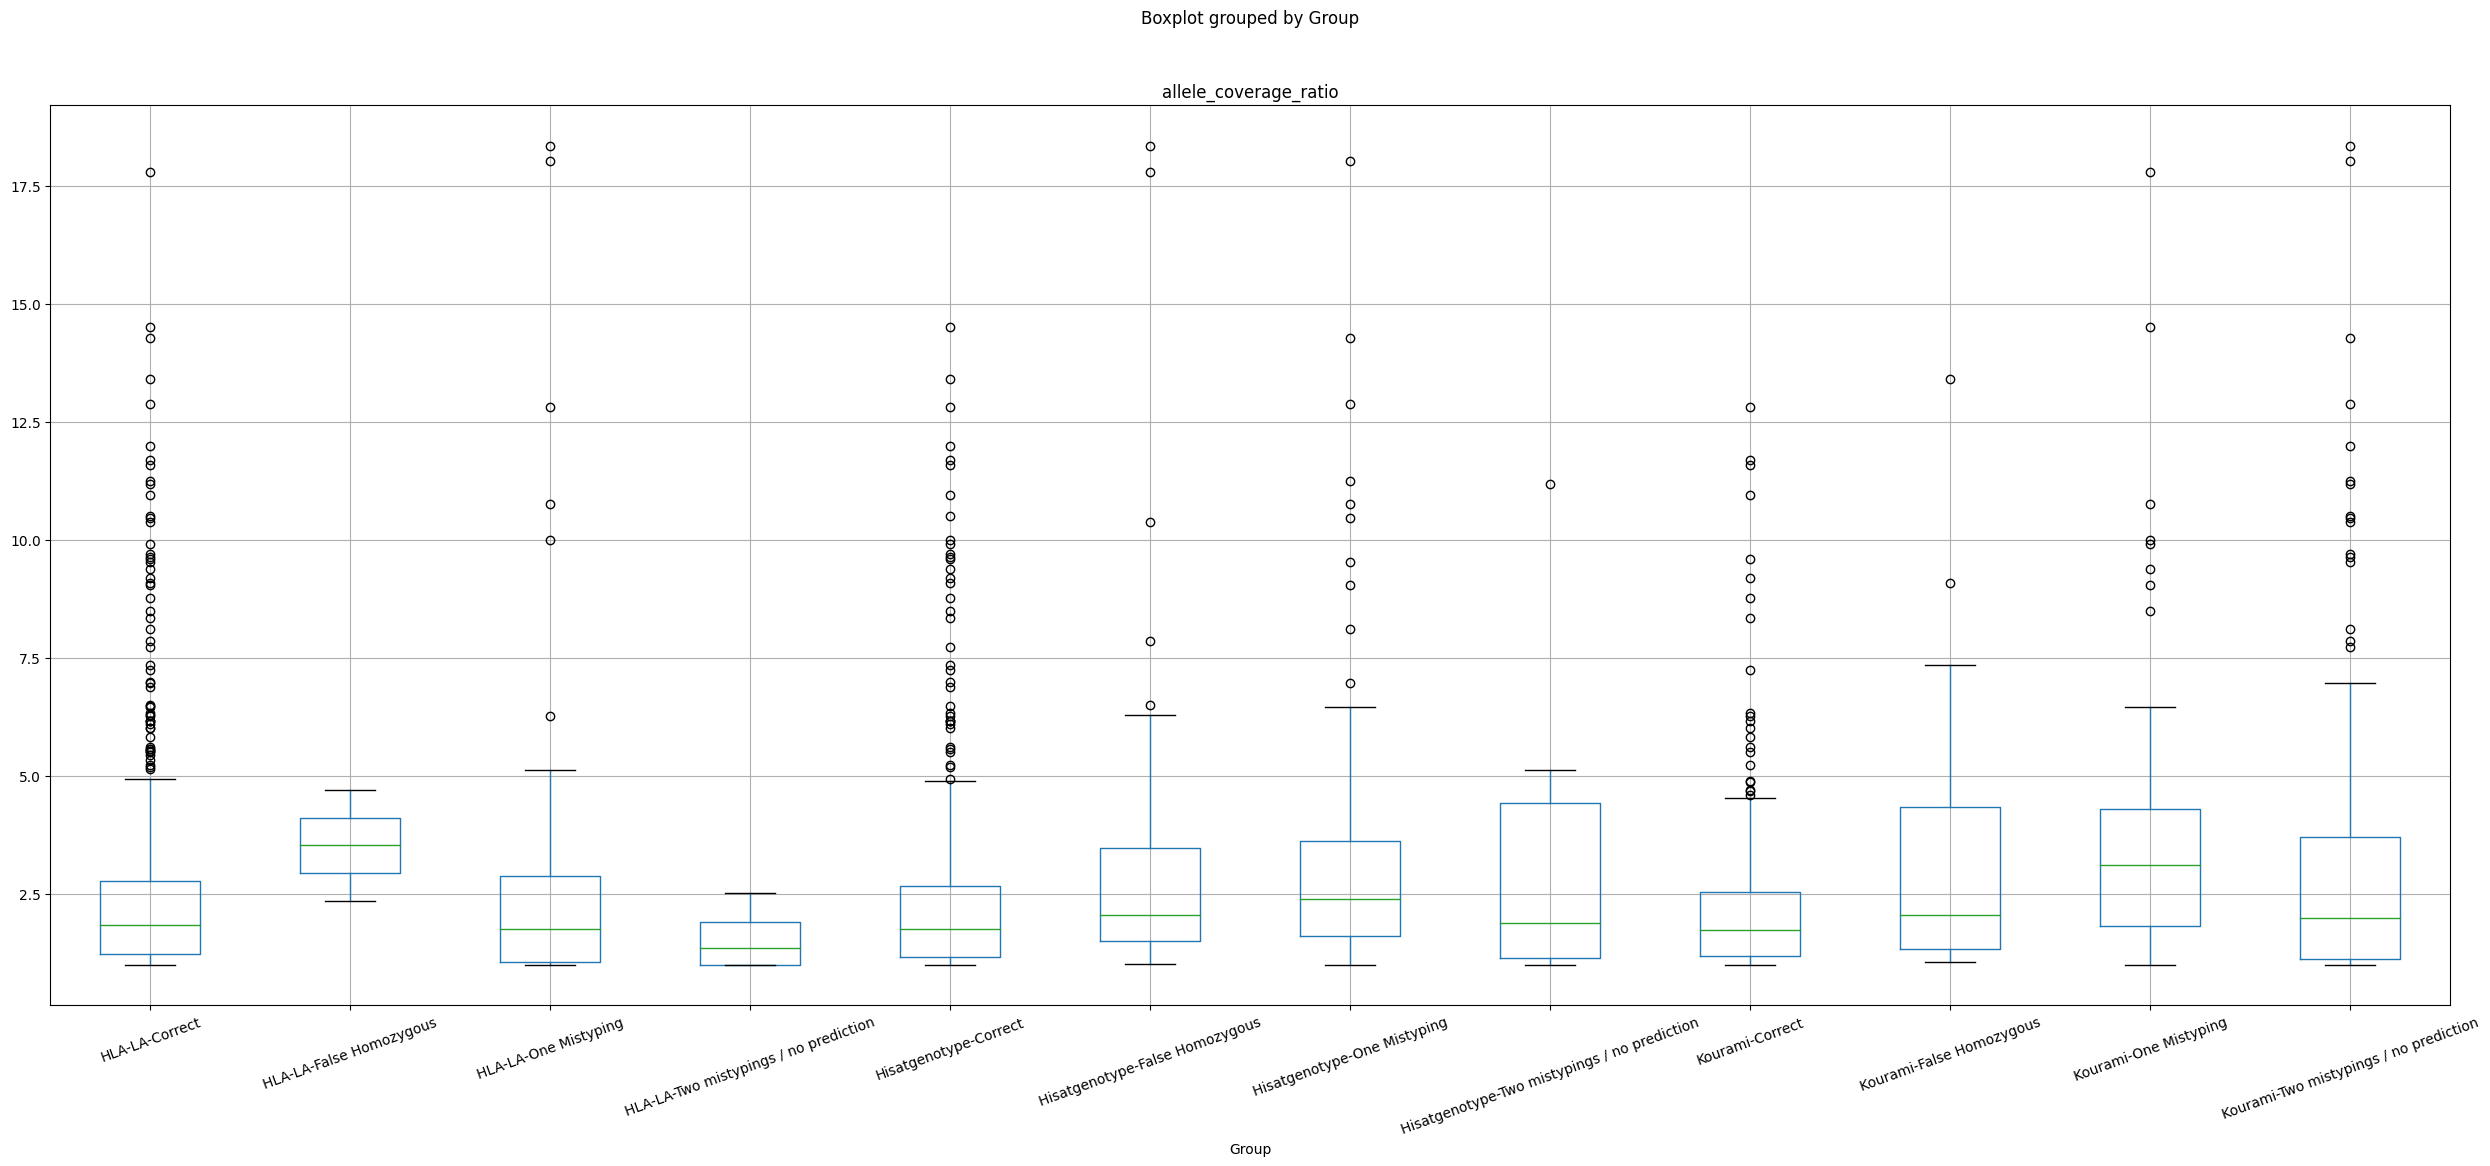

In [39]:
df_test = sample_specific_mistypings_df[['Kourami', 'Hisatgenotype', 'HLA-LA', 'allele_coverage_ratio']].melt(id_vars = ['allele_coverage_ratio'])
df_test['Group'] = df_test['variable'].astype('str') + '-' + df_test['value'].astype('str')

fig, ax = plt.subplots(figsize=(30,12))
df_test.boxplot(column = 'allele_coverage_ratio', by='Group', ax=ax)
plt.xticks(rotation=20)

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'HLA-LA-typing_result_binary-False'),
  Text(2, 0, 'HLA-LA-typing_result_binary-True'),
  Text(3, 0, 'Hisatgenotype-typing_result_binary-False'),
  Text(4, 0, 'Hisatgenotype-typing_result_binary-True'),
  Text(5, 0, 'Kourami-typing_result_binary-False'),
  Text(6, 0, 'Kourami-typing_result_binary-True')])

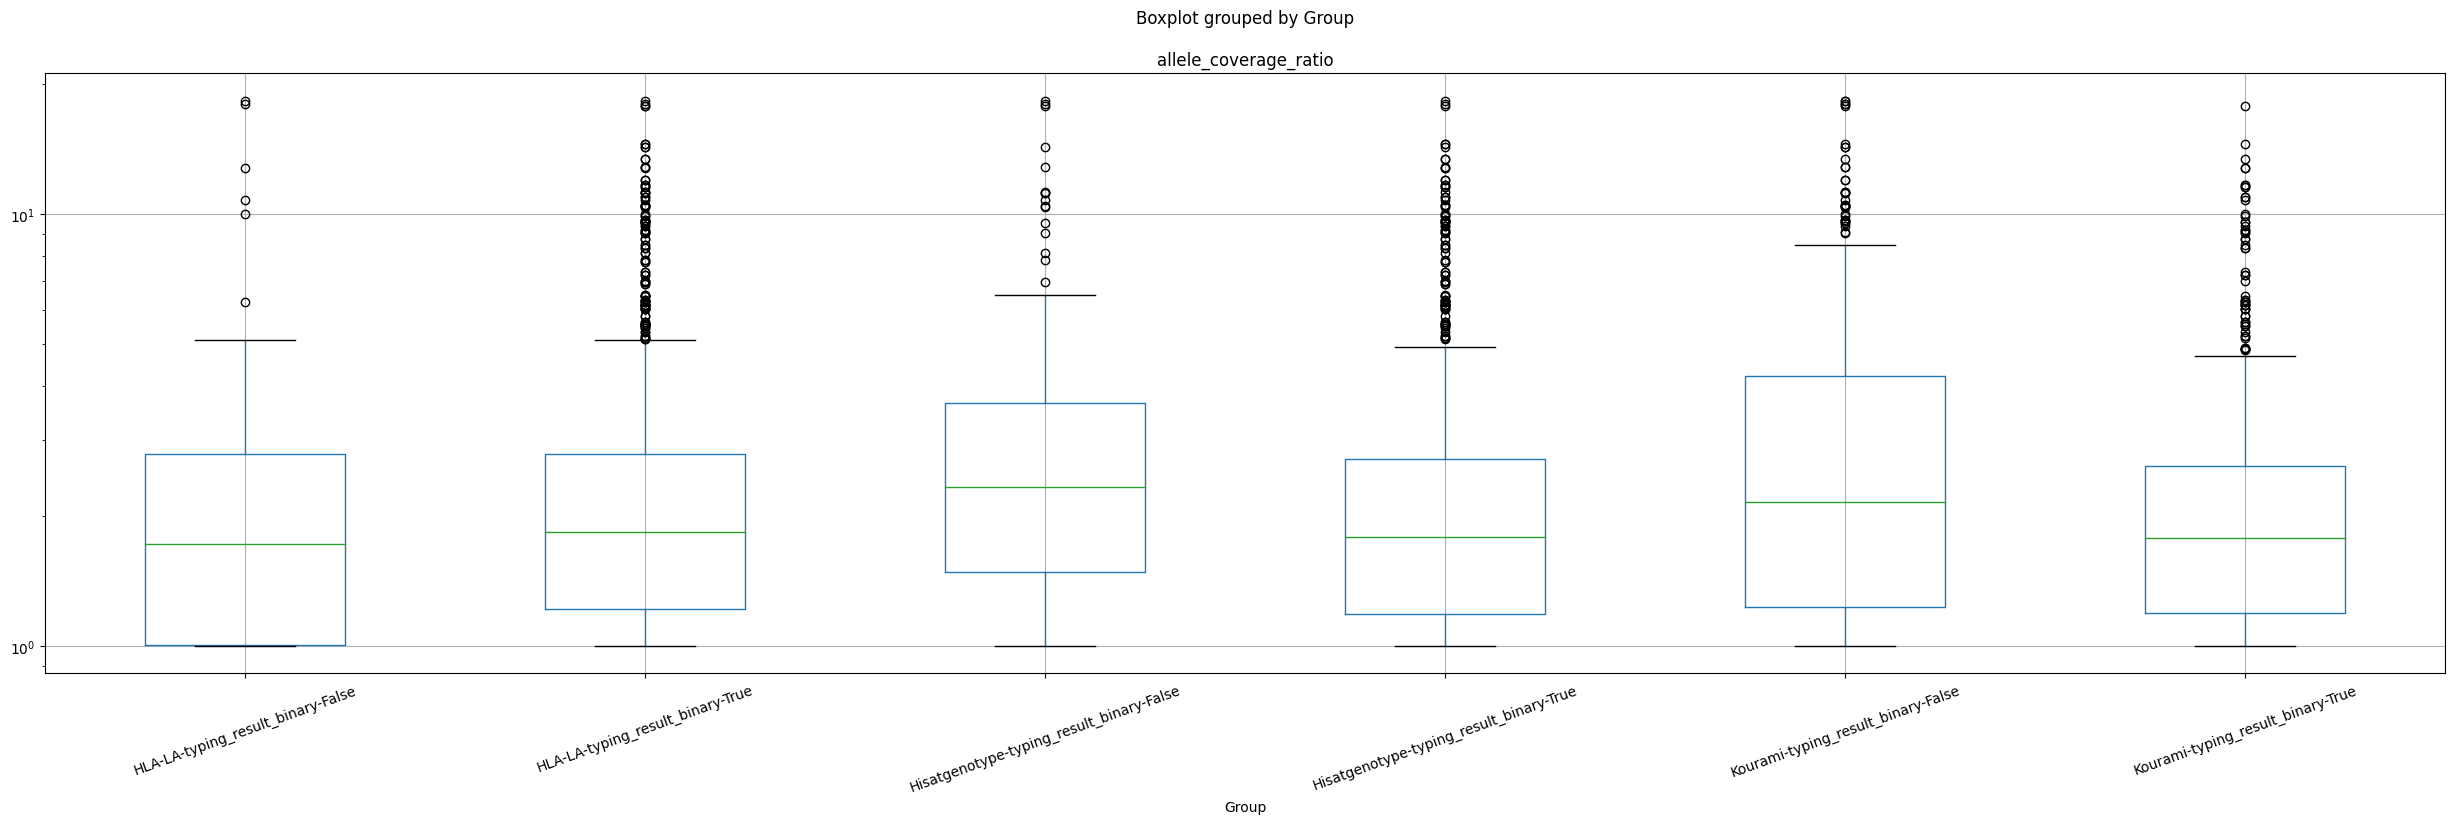

In [40]:
df_test = allele_specific_df_2[['Kourami-typing_result_binary', 'Hisatgenotype-typing_result_binary', 'HLA-LA-typing_result_binary', 'allele_coverage_ratio']].melt(id_vars = ['allele_coverage_ratio'])
df_test['Group'] = df_test['variable'].astype('str') + '-' + df_test['value'].astype('str')

fig, ax = plt.subplots(figsize=(30,8))
df_test.boxplot(column = 'allele_coverage_ratio', by='Group', ax=ax)
ax.set_yscale('log')
plt.xticks(rotation=20)

Text(0.5, 1.0, 'Depth of coverage of DQB1 (only exon 2) across correctly typed/mistyped alleles')

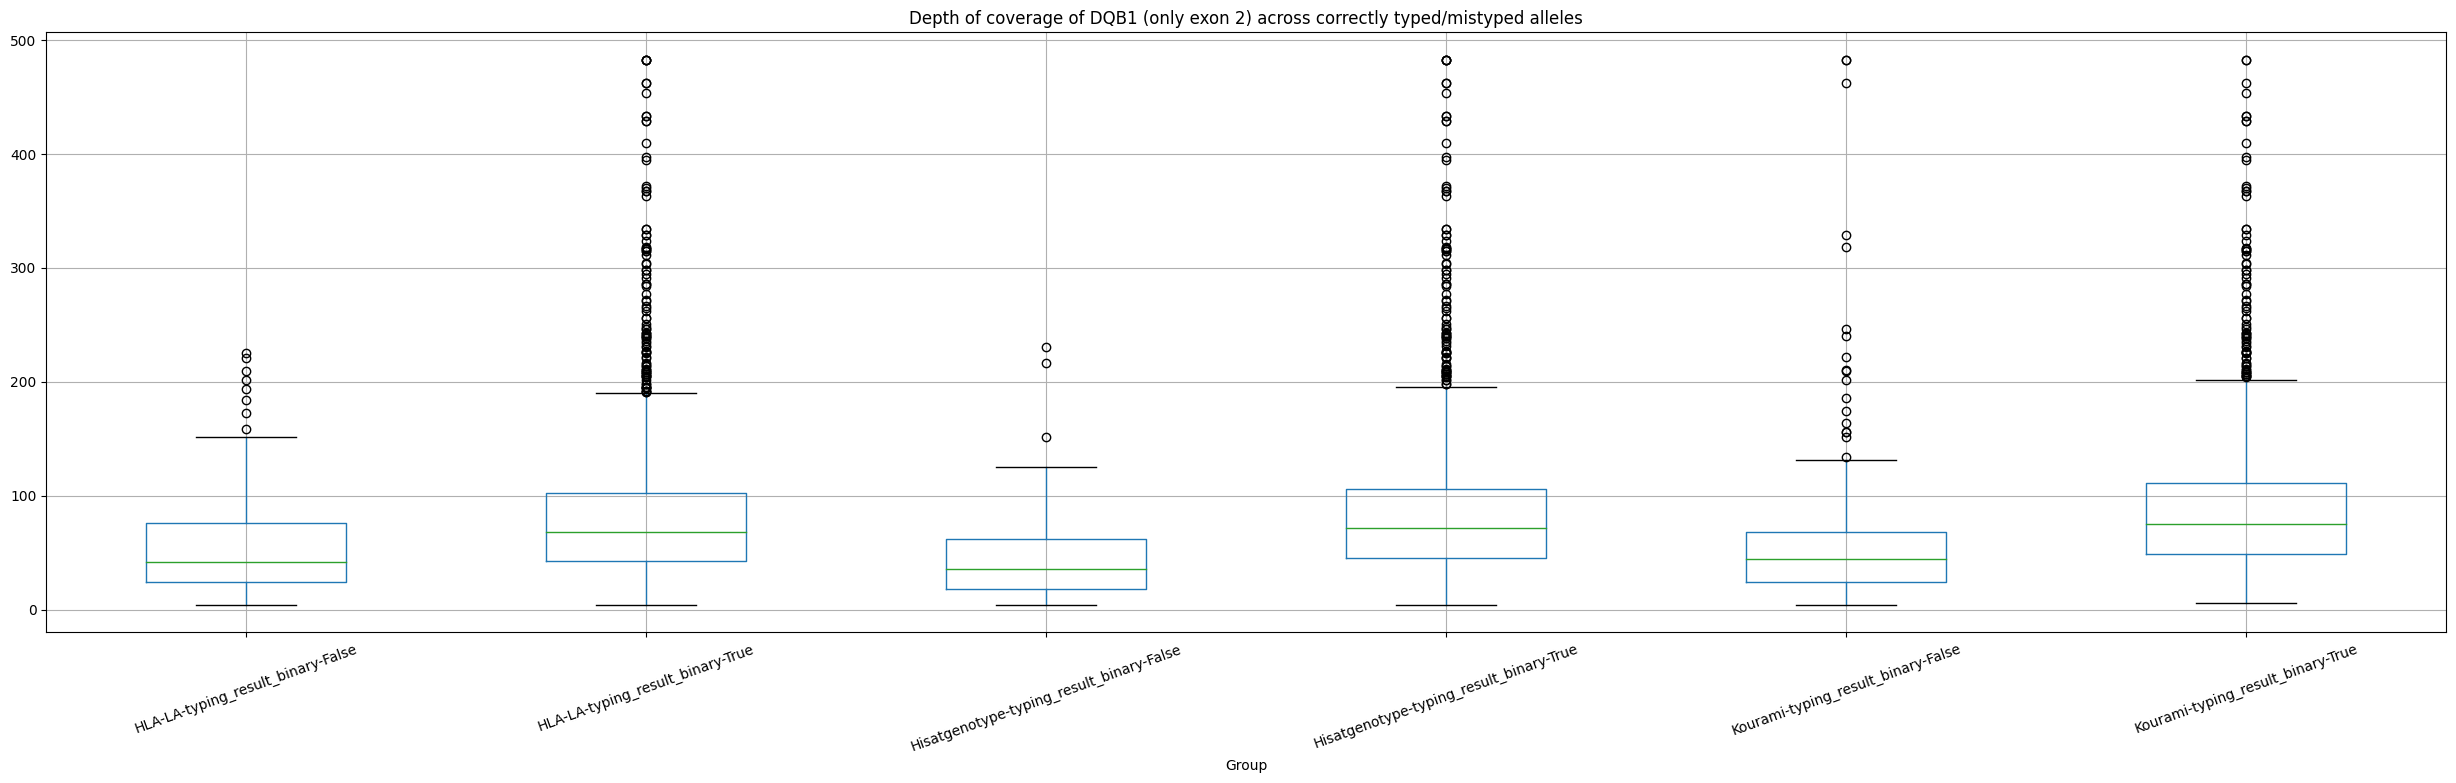

In [41]:
df_test = allele_specific_df_2[['Kourami-typing_result_binary', 'Hisatgenotype-typing_result_binary', 'HLA-LA-typing_result_binary', 'allele_coverage']].melt(id_vars = ['allele_coverage'])
df_test['Group'] = df_test['variable'].astype('str') + '-' + df_test['value'].astype('str')

fig, ax = plt.subplots(figsize=(30,8))
df_test.boxplot(column = 'allele_coverage', by='Group', ax=ax)
plt.xticks(rotation=20)
fig.suptitle('')
#ax.set_yscale('log')
plt.title('Depth of coverage of DQB1 (only exon 2) across correctly typed/mistyped alleles')

Text(0.5, 1.0, 'Depth of coverage of DQB1 (only exon 2) across correctly typed/mistyped alleles')

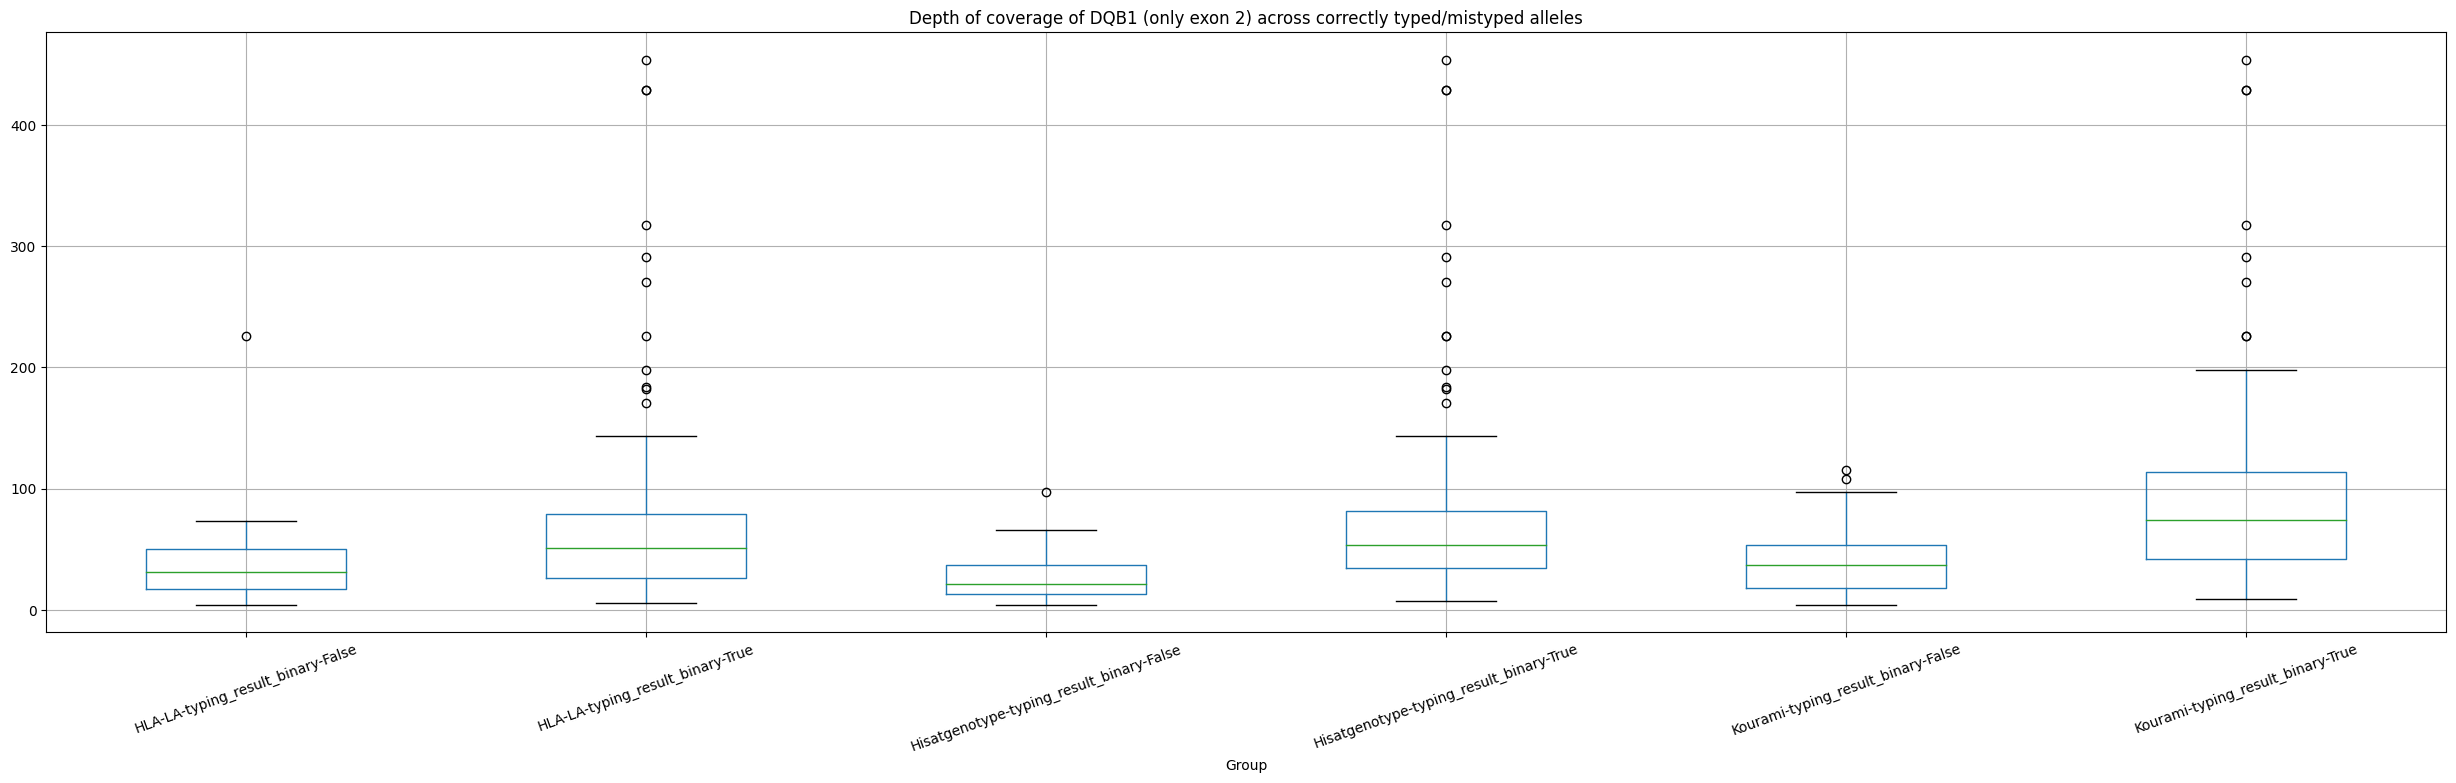

In [42]:
df_test = allele_specific_df_2[allele_specific_df_2['sample_id'].isin(eas_sampls)][['Kourami-typing_result_binary', 'Hisatgenotype-typing_result_binary', 'HLA-LA-typing_result_binary', 'allele_coverage']].melt(id_vars = ['allele_coverage'])
df_test['Group'] = df_test['variable'].astype('str') + '-' + df_test['value'].astype('str')

fig, ax = plt.subplots(figsize=(30,8))
df_test.boxplot(column = 'allele_coverage', by='Group', ax=ax)
plt.xticks(rotation=20)
fig.suptitle('')
#ax.set_yscale('log')
plt.title('Depth of coverage of DQB1 (only exon 2) across correctly typed/mistyped alleles')

In [43]:
# for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']:
#     allele_specific_df_2[['Kourami-typing_result_binary', 'Hisatgenotype-typing_result_binary', 'HLA-LA-typing_result_binary', 'allele_coverage_ratio']].boxplot(column = 'allele_coverage_ratio', by=f'{tool}-typing_result_binary')
#     allele_specific_df_eas[['Kourami-typing_result_binary', 'Hisatgenotype-typing_result_binary', 'HLA-LA-typing_result_binary', 'allele_coverage_ratio']].boxplot(column = 'allele_coverage_ratio', by=f'{tool}-typing_result_binary')


#     allele_specific_df_2[['Kourami-typing_result_binary', 'Hisatgenotype-typing_result_binary', 'HLA-LA-typing_result_binary', 'allele_coverage']].boxplot(column = 'allele_coverage', by=f'{tool}-typing_result_binary')
#     allele_specific_df_eas[['Kourami-typing_result_binary', 'Hisatgenotype-typing_result_binary', 'HLA-LA-typing_result_binary', 'allele_coverage']].boxplot(column = 'allele_coverage', by=f'{tool}-typing_result_binary')

In [44]:
# for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']:
#     allele_specific_df_2[['Kourami-typing_result', 'Hisatgenotype-typing_result', 'HLA-LA-typing_result', 'allele_coverage_ratio']].boxplot(by=f'{tool}-typing_result')
#     allele_specific_df_eas[['Kourami-typing_result', 'Hisatgenotype-typing_result', 'HLA-LA-typing_result', 'allele_coverage_ratio']].boxplot(by=f'{tool}-typing_result')


#     allele_specific_df_2[['Kourami-typing_result', 'Hisatgenotype-typing_result', 'HLA-LA-typing_result', 'allele_coverage']].boxplot(by=f'{tool}-typing_result')
#     allele_specific_df_eas[['Kourami-typing_result', 'Hisatgenotype-typing_result', 'HLA-LA-typing_result', 'allele_coverage']].boxplot(by=f'{tool}-typing_result')

In [45]:
# for typing_result, df in allele_specific_df.groupby('Hisatgenotype-typing_result'):
#     print(typing_result)
#     print(np.mean(df['allele_coverage']))
#     print(np.median(df['allele_coverage']))